In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance, ks_2samp
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)

# Define safe MAPE function to handle zero and near-zero values
def safe_mape(y_true, y_pred, epsilon=1.0):
    """
    Calculate Mean Absolute Percentage Error with protection against division by zero.
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    epsilon : float, default=1.0
        Small constant added to denominator to prevent division by zero
        
    Returns:
    --------
    float
        MAPE value (as percentage, not decimal)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Filter out negative or very small true values
    mask = y_true > epsilon
    if mask.sum() == 0:
        return np.nan  # Return NaN if no valid values
    
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    # Calculate MAPE with epsilon to prevent division by very small numbers
    mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / (y_true_filtered + epsilon))) * 100
    return mape

REG_DIR = Path("../datasets/battery_alt_dataset/regular_alt_batteries")
MAX_FILES = 5
DOWNSAMPLE_STEP = 20
ROLLING_WINDOW = 10
MAX_ALT_ROWS = 100_000

USE_DISCHARGE_ONLY = True  # True = only discharge phase, False = all modes

# Cross-Dataset Transfer Learning Analysis: Zenodo â†’ NASA
## Comprehensive Model Evaluation and Domain Adaptation Study

This notebook performs a detailed analysis of transfer learning for battery RUL prediction across different datasets.

### Load Zenodo `final_df.csv`

In [2]:
final_path = Path("../datasets/preprocessed/final_df.csv")
zenodo_df = pd.read_csv(final_path)

zen_rul_max = zenodo_df["rul"].max()
print("Zenodo RUL max =", zen_rul_max)

# Train/test split by battery_id
battery_ids = zenodo_df["battery_id"].unique()
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

train_df = zenodo_df[zenodo_df["battery_id"].isin(train_ids)].copy()
test_df  = zenodo_df[zenodo_df["battery_id"].isin(test_ids)].copy()

drop_cols = ["battery_id", "cycle_index", "rul", "time"]
feature_cols = [c for c in zenodo_df.columns if c not in drop_cols]
print("feature from Zenodo:", len(feature_cols))

display(zenodo_df.head())

Zenodo RUL max = 1299
feature from Zenodo: 39


,battery_id,cycle_index,protocol_id,discharge_capacity_ah_max,discharge_capacity_ah_mean,discharge_capacity_ah_min,charge_capacity_ah_max,charge_capacity_ah_mean,charge_capacity_ah_min,voltage_v_max,...,rolling_mean_soh_percent,rolling_std_discharge_capacity_ah_max,rolling_std_charge_capacity_ah_max,rolling_std_voltage_v_max,rolling_std_current_a_mean,rolling_std_discharge_energy_wh_max,rolling_std_charge_energy_wh_max,rolling_std_aux_temperature_1_c_mean,rolling_std_current_a_abs_mean,rolling_std_soh_percent
0,1,1,1,2.421769,0.849490,3.200319e-05,2.394174,2.115371,0.003330,4.200036,...,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,1,2.400751,0.442225,2.473989e-10,2.416324,1.819254,0.003330,4.200032,...,99.566061,0.014862,0.015662,0.000003,0.003854,0.228743,0.055605,0.524013,0.435901,0.613682
2,1,3,1,2.399412,0.442961,2.987066e-05,2.396731,1.805943,0.003330,4.200024,...,99.402985,0.012539,0.012118,0.000006,0.002735,0.187687,0.043485,0.444561,0.355911,0.517769
3,1,4,1,2.397874,0.443705,3.193769e-05,2.394747,1.803746,0.003329,4.200034,...,99.305570,0.011273,0.010610,0.000005,0.002262,0.163473,0.038482,0.387616,0.308554,0.465491
4,1,5,1,2.397038,0.443911,3.313753e-05,2.393583,1.802770,0.003329,4.200028,...,99.240217,0.010384,0.009694,0.000005,0.001984,0.146851,0.035502,0.347763,0.276177,0.428797


### Data Quality and Distribution Analysis

In [3]:
# Data Quality Assessment for Zenodo Dataset
print("="*80)
print("ZENODO DATASET - DATA QUALITY ANALYSIS")
print("="*80)

# Missing values analysis
print("\n1. Missing Values Analysis:")
missing_stats = pd.DataFrame({
    'Column': zenodo_df.columns,
    'Missing_Count': zenodo_df.isnull().sum(),
    'Missing_Percentage': (zenodo_df.isnull().sum() / len(zenodo_df) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
if len(missing_stats) > 0:
    print(missing_stats.to_string(index=False))
else:
    print("   No missing values found!")

# Outlier detection using IQR method
print("\n2. Outlier Detection (IQR Method):")
numeric_cols = zenodo_df.select_dtypes(include=[np.number]).columns
outlier_summary = []

for col in numeric_cols:
    if col not in ['battery_id', 'cycle_index']:
        Q1 = zenodo_df[col].quantile(0.25)
        Q3 = zenodo_df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((zenodo_df[col] < (Q1 - 1.5 * IQR)) | (zenodo_df[col] > (Q3 + 1.5 * IQR))).sum()
        outlier_pct = (outliers / len(zenodo_df) * 100)
        if outliers > 0:
            outlier_summary.append({
                'Feature': col,
                'Outliers': outliers,
                'Percentage': f"{outlier_pct:.2f}%"
            })

if outlier_summary:
    print(pd.DataFrame(outlier_summary).to_string(index=False))
else:
    print("   No significant outliers detected!")

# RUL distribution analysis
print("\n3. RUL Distribution Analysis:")
print(f"   RUL Range: [{zenodo_df['rul'].min():.2f}, {zenodo_df['rul'].max():.2f}]")
print(f"   RUL Mean: {zenodo_df['rul'].mean():.2f}")
print(f"   RUL Median: {zenodo_df['rul'].median():.2f}")
print(f"   RUL Std Dev: {zenodo_df['rul'].std():.2f}")
print(f"   RUL Skewness: {zenodo_df['rul'].skew():.2f}")
print(f"   RUL Kurtosis: {zenodo_df['rul'].kurtosis():.2f}")

# Battery-level statistics
print("\n4. Battery-Level Statistics:")
print(f"   Total Batteries: {zenodo_df['battery_id'].nunique()}")
print(f"   Total Cycles: {len(zenodo_df)}")
print(f"   Avg Cycles per Battery: {len(zenodo_df) / zenodo_df['battery_id'].nunique():.1f}")

battery_cycle_counts = zenodo_df.groupby('battery_id').size()
print(f"   Min Cycles: {battery_cycle_counts.min()}")
print(f"   Max Cycles: {battery_cycle_counts.max()}")
print(f"   Median Cycles: {battery_cycle_counts.median():.0f}")

ZENODO DATASET - DATA QUALITY ANALYSIS

1. Missing Values Analysis:
   No missing values found!

2. Outlier Detection (IQR Method):
                               Feature  Outliers Percentage
             discharge_capacity_ah_max       608      1.24%
             discharge_capacity_ah_min      3517      7.15%
                charge_capacity_ah_max       612      1.24%
               charge_capacity_ah_mean        79      0.16%
                charge_capacity_ah_min      8205     16.68%
                         voltage_v_max      4931     10.03%
                        voltage_v_mean        61      0.12%
                         voltage_v_min      5582     11.35%
                         voltage_v_std      3126      6.36%
                        current_a_mean     13715     27.89%
                         current_a_std        24      0.05%
               discharge_energy_wh_max       560      1.14%
                  charge_energy_wh_max       752      1.53%
              aux_temperatur

### Load NASA dataset (Regular-alt) + basic processing

In [4]:
if not REG_DIR.exists():
    raise FileNotFoundError(f"NASA folder not found: {REG_DIR.resolve()}")

csv_files = sorted(REG_DIR.glob("battery*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No battery*.csv files found in {REG_DIR.resolve()}")

csv_files = csv_files[:MAX_FILES]
print(f"\nLoading {len(csv_files)} NASA files:")
for f in csv_files:
    print(" -", f.name)

usecols = ["time", "mode", "voltage_load", "current_load", "temperature_battery"]

dfs = []
for b_id, f in enumerate(csv_files, start=1):
    tmp = pd.read_csv(f, usecols=usecols, low_memory=False)
    tmp["battery_id_alt"] = b_id
    dfs.append(tmp)

alt_raw = pd.concat(dfs, ignore_index=True)
print("\nCombined NASA shape before processing:", alt_raw.shape)

for c in ["time", "mode", "voltage_load", "current_load", "temperature_battery"]:
    if c in alt_raw.columns:
        alt_raw[c] = pd.to_numeric(alt_raw[c], errors="coerce")

# Downsample per battery
alt_raw = (alt_raw.groupby("battery_id_alt", group_keys=False).apply(lambda x: x.sort_values("time").iloc[::DOWNSAMPLE_STEP]).reset_index(drop=True))
print("NASA shape after downsampling:", alt_raw.shape)

# Select operating phases by mode
# mode: -1 = discharge, 0 = rest, 1 = charge
if "mode" in alt_raw.columns:
    alt_raw["mode"] = pd.to_numeric(alt_raw["mode"], errors="coerce")

if USE_DISCHARGE_ONLY:
    alt_raw = alt_raw[alt_raw["mode"] == -1].copy()
    print("Using discharge phase only (mode = -1). Shape:", alt_raw.shape)
else:
    mode_map = {-1: "discharge", 0: "rest", 1: "charge"}
    alt_raw["mode_flag"] = alt_raw["mode"].map(mode_map)
    alt_raw["mode_flag"] = alt_raw["mode_flag"].astype("category")
    print("Using all modes with categorical mode_flag. Value counts:")
    print(alt_raw["mode_flag"].value_counts())

    if "mode_flag" not in train_df.columns:
        train_df["mode_flag"] = "discharge"
        test_df["mode_flag"]  = "discharge"


Loading 5 NASA files:
 - battery00.csv
 - battery01.csv
 - battery10.csv
 - battery11.csv
 - battery20.csv

Combined NASA shape before processing: (12049033, 6)
NASA shape after downsampling: (602455, 6)
Using discharge phase only (mode = -1). Shape: (86191, 6)


### Compute RUL for NASA + rolling features + align structure

In [5]:
# Compute RUL for Regular-alt and rescale to match Zenodo
alt_raw = alt_raw.sort_values(["battery_id_alt", "time"]).reset_index(drop=True)

alt_raw["rul_raw"] = 0.0
for bid, sub in alt_raw.groupby("battery_id_alt"):
    t_end = sub["time"].max()
    alt_raw.loc[sub.index, "rul_raw"] = t_end - sub["time"]

raw_max = alt_raw["rul_raw"].max()
alt_raw["rul"] = alt_raw["rul_raw"] / raw_max * zen_rul_max

print("NASA RUL_raw max:", raw_max)
print("NASA RUL max after rescale:", alt_raw["rul"].max())
print(alt_raw.shape)
print(alt_raw.columns.tolist())

# Map column names
rename_map = {"voltage_load": "voltage_v_mean","current_load": "current_a_mean","temperature_battery": "aux_temperature_1_c_mean"}
alt_raw = alt_raw.rename(columns=rename_map, errors="ignore")

if "current_a_mean" in alt_raw.columns:
    alt_raw["current_a_abs_mean"] = alt_raw["current_a_mean"].abs()

window = ROLLING_WINDOW
bases = ["voltage_v_mean","current_a_mean","aux_temperature_1_c_mean","current_a_abs_mean"]
parts = []
for bid, sub in alt_raw.groupby("battery_id_alt", sort=False):
    sub = sub.sort_values("time").copy()
    for base in bases:
        if base not in sub.columns:
            continue
        sub[f"rolling_mean_{base}"] = (sub[base].shift(1).rolling(window, min_periods=1).mean())
        sub[f"rolling_std_{base}"] = (sub[base].shift(1).rolling(window, min_periods=1).std())
    parts.append(sub)

alt_raw = pd.concat(parts, ignore_index=True)
print("NASA shape after adding rolling features:", alt_raw.shape)
print(alt_raw.columns.tolist())

alt_aligned = alt_raw.copy()
alt_aligned["battery_id"] = alt_aligned["battery_id_alt"]

keep_cols = ["battery_id", "time", "rul"]
for c in ["voltage_v_mean",
            "current_a_mean",
            "aux_temperature_1_c_mean",
            "current_a_abs_mean",]:
    if c in alt_aligned.columns:
        keep_cols.append(c)

keep_cols += [c for c in alt_aligned.columns if c.startswith("rolling_mean_") or c.startswith("rolling_std_")]

if "mode_flag" in alt_aligned.columns:
    keep_cols.append("mode_flag")

alt_aligned = alt_aligned[keep_cols].reset_index(drop=True)
print("NASA aligned shape:", alt_aligned.shape)

if len(alt_aligned) > MAX_ALT_ROWS:
    alt_aligned = alt_aligned.sample(n=MAX_ALT_ROWS, random_state=42).reset_index(drop=True)
    print("Aligned NASA shape after sampling:", alt_aligned.shape)

NASA RUL_raw max: 4916734.167
NASA RUL max after rescale: 1299.0
(86191, 8)
['time', 'mode', 'temperature_battery', 'voltage_load', 'current_load', 'battery_id_alt', 'rul_raw', 'rul']
NASA shape after adding rolling features: (86191, 17)
['time', 'mode', 'aux_temperature_1_c_mean', 'voltage_v_mean', 'current_a_mean', 'battery_id_alt', 'rul_raw', 'rul', 'current_a_abs_mean', 'rolling_mean_voltage_v_mean', 'rolling_std_voltage_v_mean', 'rolling_mean_current_a_mean', 'rolling_std_current_a_mean', 'rolling_mean_aux_temperature_1_c_mean', 'rolling_std_aux_temperature_1_c_mean', 'rolling_mean_current_a_abs_mean', 'rolling_std_current_a_abs_mean']
NASA aligned shape: (86191, 15)


### NASA Dataset Quality Analysis

In [6]:
# Data Quality Assessment for NASA Dataset
print("="*80)
print("NASA DATASET - DATA QUALITY ANALYSIS")
print("="*80)

# Missing values analysis
print("\n1. Missing Values Analysis:")
missing_stats_nasa = pd.DataFrame({
    'Column': alt_aligned.columns,
    'Missing_Count': alt_aligned.isnull().sum(),
    'Missing_Percentage': (alt_aligned.isnull().sum() / len(alt_aligned) * 100).round(2)
})
missing_stats_nasa = missing_stats_nasa[missing_stats_nasa['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
if len(missing_stats_nasa) > 0:
    print(missing_stats_nasa.to_string(index=False))
else:
    print("   No missing values found!")

# RUL distribution analysis
print("\n2. RUL Distribution Analysis:")
print(f"   RUL Range: [{alt_aligned['rul'].min():.2f}, {alt_aligned['rul'].max():.2f}]")
print(f"   RUL Mean: {alt_aligned['rul'].mean():.2f}")
print(f"   RUL Median: {alt_aligned['rul'].median():.2f}")
print(f"   RUL Std Dev: {alt_aligned['rul'].std():.2f}")
print(f"   RUL Skewness: {alt_aligned['rul'].skew():.2f}")
print(f"   RUL Kurtosis: {alt_aligned['rul'].kurtosis():.2f}")

# Battery-level statistics
print("\n3. Battery-Level Statistics:")
print(f"   Total Batteries: {alt_aligned['battery_id'].nunique()}")
print(f"   Total Samples: {len(alt_aligned)}")
print(f"   Avg Samples per Battery: {len(alt_aligned) / alt_aligned['battery_id'].nunique():.1f}")

NASA DATASET - DATA QUALITY ANALYSIS

1. Missing Values Analysis:
                               Column  Missing_Count  Missing_Percentage
           rolling_std_voltage_v_mean             10                0.01
           rolling_std_current_a_mean             10                0.01
       rolling_std_current_a_abs_mean             10                0.01
 rolling_std_aux_temperature_1_c_mean             10                0.01
          rolling_mean_current_a_mean              5                0.01
          rolling_mean_voltage_v_mean              5                0.01
rolling_mean_aux_temperature_1_c_mean              5                0.01
      rolling_mean_current_a_abs_mean              5                0.01

2. RUL Distribution Analysis:
   RUL Range: [0.00, 1299.00]
   RUL Mean: 599.21
   RUL Median: 578.37
   RUL Std Dev: 394.62
   RUL Skewness: 0.13
   RUL Kurtosis: -1.29

3. Battery-Level Statistics:
   Total Batteries: 5
   Total Samples: 86191
   Avg Samples per Battery: 17

### Common features + base matrices (Zenodo & NASA)

In [7]:
common_features = [f for f in feature_cols if f in alt_aligned.columns]
print("\nNumber of common features (Zenodo âˆ© NASA):", len(common_features))

if "mode_flag" in alt_aligned.columns and "mode_flag" not in train_df.columns:
    train_df["mode_flag"] = "discharge"
    test_df["mode_flag"]  = "discharge"

# Zenodo
X_train_base = train_df[common_features].copy()
X_test       = test_df[common_features].copy()
y_train_base = train_df["rul"].values
y_test       = test_df["rul"].values

# NASA full
X_alt_full = alt_aligned[common_features].copy()
y_alt_full = alt_aligned["rul"].values

print("Zenodo train:", X_train_base.shape,"| Zenodo test:", X_test.shape,"| NASA full:", X_alt_full.shape)


Number of common features (Zenodo âˆ© NASA): 10
Zenodo train: (39923, 10) | Zenodo test: (9258, 10) | NASA full: (86191, 10)


### Distribution Shift Quantification

In [8]:
# Quantitative Distribution Shift Analysis
print("="*80)
print("DISTRIBUTION SHIFT ANALYSIS: Zenodo vs NASA")
print("="*80)

# Select numeric features for comparison
numeric_features_common = [f for f in common_features 
                          if f in train_df.select_dtypes(include=[np.number]).columns 
                          and f in alt_aligned.select_dtypes(include=[np.number]).columns]

distribution_stats = []

for feat in numeric_features_common[:10]:  # Analyze top 10 features
    # Get clean data (no NaN)
    zenodo_vals = train_df[feat].dropna()
    nasa_vals = alt_aligned[feat].dropna()
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = ks_2samp(zenodo_vals, nasa_vals)
    
    # Wasserstein distance
    wasserstein_dist = wasserstein_distance(zenodo_vals, nasa_vals)
    
    # Mean and std comparison
    mean_diff = abs(zenodo_vals.mean() - nasa_vals.mean())
    std_ratio = zenodo_vals.std() / nasa_vals.std() if nasa_vals.std() > 0 else np.inf
    
    distribution_stats.append({
        'Feature': feat,
        'KS_Statistic': f"{ks_stat:.4f}",
        'KS_P_Value': f"{ks_pvalue:.4e}",
        'Wasserstein_Dist': f"{wasserstein_dist:.4f}",
        'Mean_Diff': f"{mean_diff:.4f}",
        'Std_Ratio': f"{std_ratio:.4f}",
        'Significant_Shift': 'Yes' if ks_pvalue < 0.05 else 'No'
    })

dist_df = pd.DataFrame(distribution_stats)
print("\nStatistical Tests for Distribution Shift:")
print(dist_df.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION:")
print("â€¢ KS Statistic > 0.2: Strong distribution difference")
print("â€¢ P-Value < 0.05: Statistically significant difference")
print("â€¢ Wasserstein Distance: Higher = more distribution shift")
print("="*80)

DISTRIBUTION SHIFT ANALYSIS: Zenodo vs NASA

Statistical Tests for Distribution Shift:
                              Feature KS_Statistic KS_P_Value Wasserstein_Dist Mean_Diff Std_Ratio Significant_Shift
                       voltage_v_mean       0.9987 0.0000e+00           2.7885    2.7784    0.0738               Yes
                       current_a_mean       1.0000 0.0000e+00           9.0152    9.0152    0.0062               Yes
             aux_temperature_1_c_mean       0.8152 0.0000e+00          17.0103   16.9812    0.0689               Yes
                   current_a_abs_mean       0.9975 0.0000e+00           8.0018    8.0018    0.0844               Yes
          rolling_mean_current_a_mean       1.0000 0.0000e+00           9.0117    9.0117    0.0048               Yes
rolling_mean_aux_temperature_1_c_mean       0.8878 0.0000e+00          16.9861   16.9723    0.0648               Yes
      rolling_mean_current_a_abs_mean       1.0000 0.0000e+00           7.9983    7.9983    0.


FEATURE CORRELATION ANALYSIS


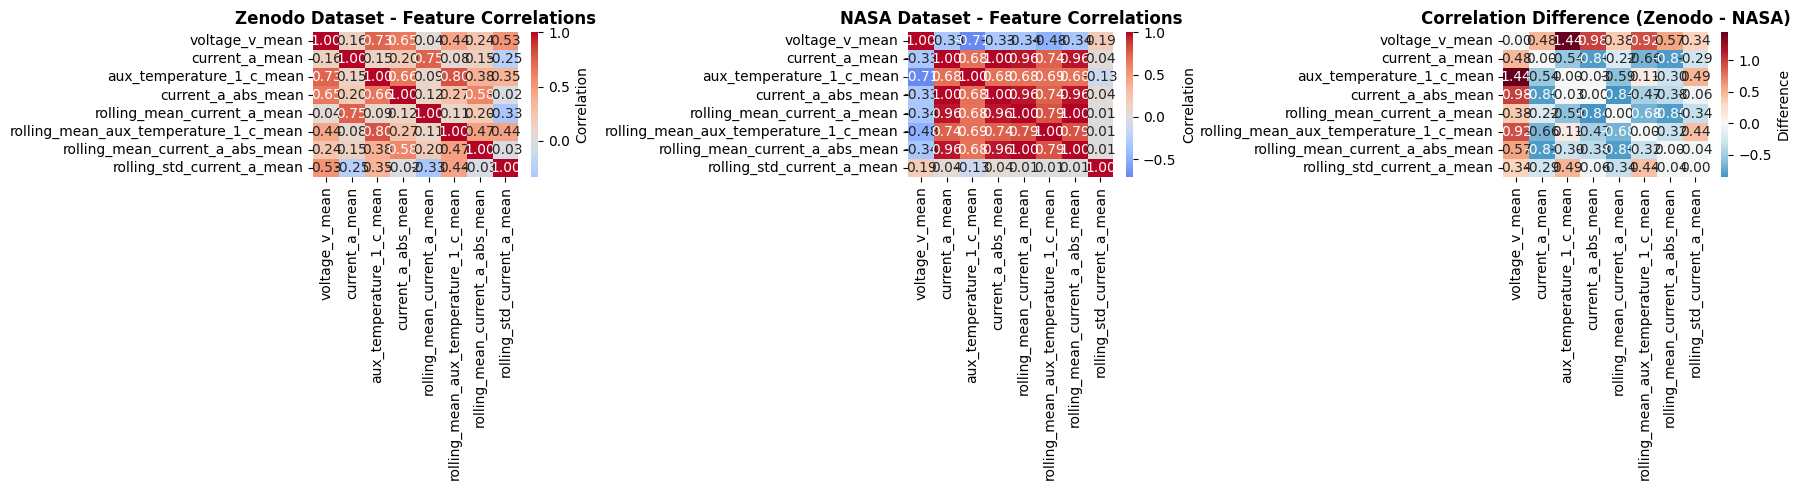


Top 10 Feature Pairs with Largest Correlation Differences:
                                                       Feature_Pair  Zenodo_Corr  NASA_Corr  Difference
                          voltage_v_mean - aux_temperature_1_c_mean     0.730403  -0.707810    1.438213
                                voltage_v_mean - current_a_abs_mean     0.652836  -0.326563    0.979399
             voltage_v_mean - rolling_mean_aux_temperature_1_c_mean     0.441267  -0.483143    0.924410
                   current_a_abs_mean - rolling_mean_current_a_mean     0.117588   0.962575    0.844987
                   current_a_mean - rolling_mean_current_a_abs_mean     0.150700   0.962575    0.811875
      rolling_mean_current_a_mean - rolling_mean_current_a_abs_mean     0.200048   1.000000    0.799952
                                current_a_mean - current_a_abs_mean     0.200773   1.000000    0.799227
rolling_mean_current_a_mean - rolling_mean_aux_temperature_1_c_mean     0.109595   0.790293    0.680699
    

In [9]:
# Feature Correlation Comparison
print("\n" + "="*80)
print("FEATURE CORRELATION ANALYSIS")
print("="*80)

# Compute correlation matrices
zenodo_corr = train_df[numeric_features_common[:8]].corr()
nasa_corr = alt_aligned[numeric_features_common[:8]].corr()

# Visualize correlation matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Zenodo correlation
sns.heatmap(zenodo_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Zenodo Dataset - Feature Correlations', fontsize=12, fontweight='bold')

# NASA correlation
sns.heatmap(nasa_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('NASA Dataset - Feature Correlations', fontsize=12, fontweight='bold')

# Correlation difference
corr_diff = zenodo_corr - nasa_corr
sns.heatmap(corr_diff, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=axes[2], cbar_kws={'label': 'Difference'})
axes[2].set_title('Correlation Difference (Zenodo - NASA)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Find largest correlation differences
corr_diff_flat = []
for i in range(len(corr_diff.columns)):
    for j in range(i+1, len(corr_diff.columns)):
        corr_diff_flat.append({
            'Feature_Pair': f"{corr_diff.columns[i]} - {corr_diff.columns[j]}",
            'Zenodo_Corr': zenodo_corr.iloc[i, j],
            'NASA_Corr': nasa_corr.iloc[i, j],
            'Difference': abs(corr_diff.iloc[i, j])
        })

corr_diff_df = pd.DataFrame(corr_diff_flat).sort_values('Difference', ascending=False).head(10)
print("\nTop 10 Feature Pairs with Largest Correlation Differences:")
print(corr_diff_df.to_string(index=False))

### Preprocessing and Random Forest pipeline

In [10]:
def build_rf_global():
    numeric_features = X_train_base.select_dtypes(include=["int64", "float64"]).columns
    categorical_features = X_train_base.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),("scaler", StandardScaler())])
    categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("encoder", OneHotEncoder(handle_unknown="ignore"))])

    transformers = []
    if len(numeric_features) > 0:
        transformers.append(("num", numeric_transformer, numeric_features))
    if len(categorical_features) > 0:
        transformers.append(("cat", categorical_transformer, categorical_features))

    preprocess = ColumnTransformer(transformers=transformers)
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=16,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,)

    model = Pipeline(steps=[("preprocess", preprocess), ("rf", rf)])
    return model

### Baseline (Zenodo only â†’ Zenodo & NASA)

In [11]:
model_base = build_rf_global()
model_base.fit(X_train_base, y_train_base)

# Zenodo test
y_pred_zen_base = model_base.predict(X_test)
r2_zen_base   = r2_score(y_test, y_pred_zen_base)
rmse_zen_base = mean_squared_error(y_test, y_pred_zen_base) ** 0.5
mae_zen_base  = mean_absolute_error(y_test, y_pred_zen_base)

# NASA cross-dataset: use full NASA
y_pred_alt_base = model_base.predict(X_alt_full)
r2_alt_base   = r2_score(y_alt_full, y_pred_alt_base)
rmse_alt_base = mean_squared_error(y_alt_full, y_pred_alt_base) ** 0.5
mae_alt_base  = mean_absolute_error(y_alt_full, y_pred_alt_base)

print("=== BASELINE RF (Train: Zenodo â†’ Test: Zenodo) ===")
print(f"RÂ²   : {r2_zen_base:.4f}")
print(f"RMSE : {rmse_zen_base:.2f}")
print(f"MAE  : {mae_zen_base:.2f}")

print("\n=== BASELINE RF Cross-Dataset (Train: Zenodo â†’ Test: NASA full) ===")
print(f"RÂ²   : {r2_alt_base:.4f}")
print(f"RMSE : {rmse_alt_base:.2f}")
print(f"MAE  : {mae_alt_base:.2f}")

=== BASELINE RF (Train: Zenodo â†’ Test: Zenodo) ===
RÂ²   : 0.8162
RMSE : 180.12
MAE  : 106.97

=== BASELINE RF Cross-Dataset (Train: Zenodo â†’ Test: NASA full) ===
RÂ²   : -4.5587
RMSE : 930.38
MAE  : 774.96


### Baseline Model - Detailed Diagnostics

In [12]:
# Baseline Model - Additional Metrics and Confidence Intervals
print("="*80)
print("BASELINE MODEL - COMPREHENSIVE EVALUATION")
print("="*80)

# Additional metrics for Zenodo test
mape_zen_base = safe_mape(y_test, y_pred_zen_base)
evs_zen_base = explained_variance_score(y_test, y_pred_zen_base)
max_error_zen = np.max(np.abs(y_test - y_pred_zen_base))

print("\n--- Zenodo Test Set ---")
print(f"RÂ² Score:                {r2_zen_base:.4f}")
print(f"RMSE:                    {rmse_zen_base:.2f}")
print(f"MAE:                     {mae_zen_base:.2f}")
print(f"MAPE:                    {mape_zen_base:.2f}%" if not np.isnan(mape_zen_base) else "MAPE:                    N/A (insufficient valid data)")
print(f"Explained Variance:      {evs_zen_base:.4f}")
print(f"Max Error:               {max_error_zen:.2f}")

# Bootstrap confidence intervals for Zenodo
n_bootstrap = 100
bootstrap_r2 = []
bootstrap_rmse = []

np.random.seed(42)
for _ in range(n_bootstrap):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_true_boot = y_test[indices]
    y_pred_boot = y_pred_zen_base[indices]
    
    bootstrap_r2.append(r2_score(y_true_boot, y_pred_boot))
    bootstrap_rmse.append(np.sqrt(mean_squared_error(y_true_boot, y_pred_boot)))

r2_ci = np.percentile(bootstrap_r2, [2.5, 97.5])
rmse_ci = np.percentile(bootstrap_rmse, [2.5, 97.5])

print(f"\n95% Confidence Intervals (Bootstrap, n={n_bootstrap}):")
print(f"RÂ² CI:                   [{r2_ci[0]:.4f}, {r2_ci[1]:.4f}]")
print(f"RMSE CI:                 [{rmse_ci[0]:.2f}, {rmse_ci[1]:.2f}]")

# Additional metrics for NASA
mape_alt_base = safe_mape(y_alt_full, y_pred_alt_base)
evs_alt_base = explained_variance_score(y_alt_full, y_pred_alt_base)
max_error_alt = np.max(np.abs(y_alt_full - y_pred_alt_base))

print("\n--- NASA Cross-Dataset Test ---")
print(f"RÂ² Score:                {r2_alt_base:.4f}")
print(f"RMSE:                    {rmse_alt_base:.2f}")
print(f"MAE:                     {mae_alt_base:.2f}")
print(f"MAPE:                    {mape_alt_base:.2f}%" if not np.isnan(mape_alt_base) else "MAPE:                    N/A (insufficient valid data)")
print(f"Explained Variance:      {evs_alt_base:.4f}")
print(f"Max Error:               {max_error_alt:.2f}")

print("\n" + "="*80)

BASELINE MODEL - COMPREHENSIVE EVALUATION

--- Zenodo Test Set ---
RÂ² Score:                0.8162
RMSE:                    180.12
MAE:                     106.97
MAPE:                    59.88%
Explained Variance:      0.8276
Max Error:               937.18

95% Confidence Intervals (Bootstrap, n=100):
RÂ² CI:                   [0.8088, 0.8234]
RMSE CI:                 [176.20, 184.67]

--- NASA Cross-Dataset Test ---
RÂ² Score:                -4.5587
RMSE:                    930.38
MAE:                     774.96
MAPE:                    262.23%
Explained Variance:      -0.7433
Max Error:               2139.24



ERROR ANALYSIS BY RUL SEGMENTS - Baseline on NASA

Performance by RUL Segment:
    RUL_Segment         Range  N_Samples           R2       RMSE        MAE
    End-of-Life       [0, 20)       2260 -5499.385392 413.377476 279.520643
       Mid-Life      [20, 50)       3168 -2329.718823 418.251079 272.348462
     Early-Life     [50, 100)       4689  -755.699271 389.474558 231.810728
Very Early-Life [100, 1299.0)      76073    -6.348940 979.291875 844.081995


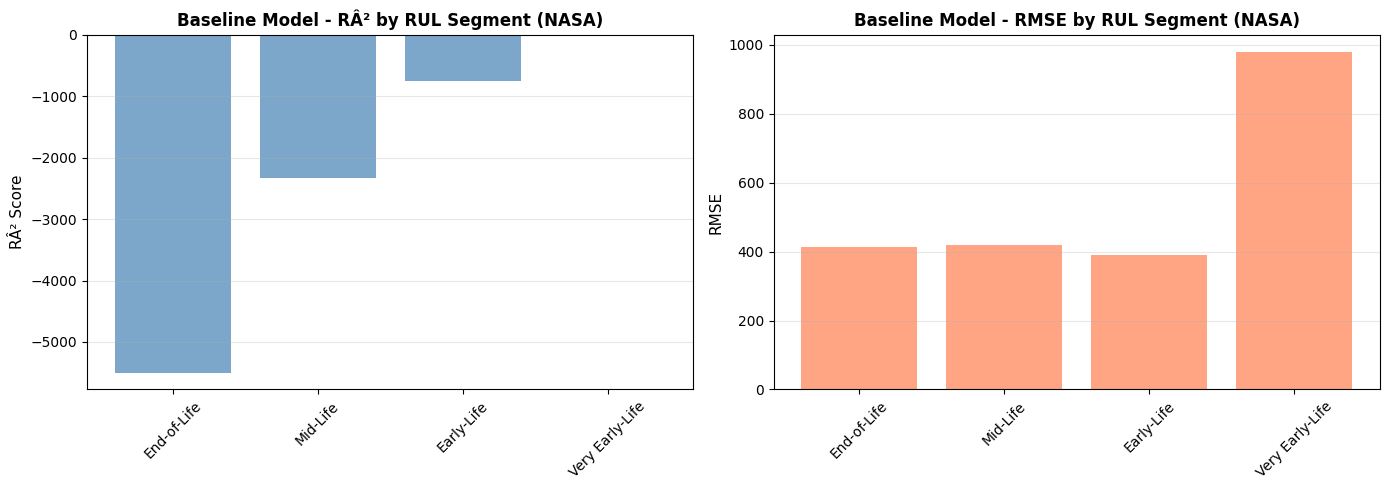

In [13]:
# Error Analysis by RUL Segments (Baseline on NASA)
print("="*80)
print("ERROR ANALYSIS BY RUL SEGMENTS - Baseline on NASA")
print("="*80)

# Define RUL segments
rul_segments = [
    (0, 20, 'End-of-Life'),
    (20, 50, 'Mid-Life'),
    (50, 100, 'Early-Life'),
    (100, y_alt_full.max(), 'Very Early-Life')
]

segment_results = []
for min_rul, max_rul, label in rul_segments:
    mask = (y_alt_full >= min_rul) & (y_alt_full < max_rul)
    if mask.sum() > 0:
        y_true_seg = y_alt_full[mask]
        y_pred_seg = y_pred_alt_base[mask]
        
        segment_results.append({
            'RUL_Segment': label,
            'Range': f"[{min_rul}, {max_rul})",
            'N_Samples': mask.sum(),
            'R2': r2_score(y_true_seg, y_pred_seg),
            'RMSE': np.sqrt(mean_squared_error(y_true_seg, y_pred_seg)),
            'MAE': mean_absolute_error(y_true_seg, y_pred_seg)
        })

segment_df = pd.DataFrame(segment_results)
print("\nPerformance by RUL Segment:")
print(segment_df.to_string(index=False))

# Visualize segment performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(segment_df['RUL_Segment'], segment_df['R2'], color='steelblue', alpha=0.7)
axes[0].set_ylabel('RÂ² Score', fontsize=11)
axes[0].set_title('Baseline Model - RÂ² by RUL Segment (NASA)', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(segment_df['RUL_Segment'], segment_df['RMSE'], color='coral', alpha=0.7)
axes[1].set_ylabel('RMSE', fontsize=11)
axes[1].set_title('Baseline Model - RMSE by RUL Segment (NASA)', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Fine-tune 5% / 10% / 15% NASA

In [14]:
ratios = [5, 10, 15]
metrics = []

model_ft_5 = None
model_ft_10 = None
model_ft_15 = None

X_alt_test_5 = y_alt_test_5 = None
X_alt_test_10 = y_alt_test_10 = None
X_alt_test_15 = y_alt_test_15 = None

for ratio in ratios:
    frac = ratio / 100.0
    alt_fine = alt_aligned.sample(frac=frac, random_state=42)
    alt_test = alt_aligned.drop(alt_fine.index)

    X_alt_fine = alt_fine[common_features].copy()
    y_alt_fine = alt_fine["rul"].values

    X_alt_test = alt_test[common_features].copy()
    y_alt_test = alt_test["rul"].values

    X_finetune = pd.concat([X_train_base, X_alt_fine], axis=0)
    y_finetune = np.concatenate([y_train_base, y_alt_fine])

    model_ft = build_rf_global()
    model_ft.fit(X_finetune, y_finetune)

    if ratio == 5:
        model_ft_5 = model_ft
        X_alt_fine_5 = X_alt_fine    
        y_alt_fine_5 = y_alt_fine    
        X_alt_test_5 = X_alt_test
        y_alt_test_5 = y_alt_test
    elif ratio == 10:
        model_ft_10 = model_ft
        X_alt_fine_10 = X_alt_fine   
        y_alt_fine_10 = y_alt_fine 
        X_alt_test_10 = X_alt_test
        y_alt_test_10 = y_alt_test
    elif ratio == 15:
        model_ft_15 = model_ft
        X_alt_fine_15 = X_alt_fine   
        y_alt_fine_15 = y_alt_fine  
        X_alt_test_15 = X_alt_test
        y_alt_test_15 = y_alt_test


    # Evaluate on Zenodo test
    y_pred_zen = model_ft.predict(X_test)
    r2_zen   = r2_score(y_test, y_pred_zen)
    rmse_zen = mean_squared_error(y_test, y_pred_zen) ** 0.5
    mae_zen  = mean_absolute_error(y_test, y_pred_zen)
    mape_zen = safe_mape(y_test, y_pred_zen)
    evs_zen = explained_variance_score(y_test, y_pred_zen)

    # Evaluate on NASA test (cross-dataset)
    y_pred_alt = model_ft.predict(X_alt_test)
    r2_alt   = r2_score(y_alt_test, y_pred_alt)
    rmse_alt = mean_squared_error(y_alt_test, y_pred_alt) ** 0.5
    mae_alt  = mean_absolute_error(y_alt_test, y_pred_alt)
    mape_alt = safe_mape(y_alt_test, y_pred_alt)
    evs_alt = explained_variance_score(y_alt_test, y_pred_alt)

    print(f"\n=== FINE-TUNED RF ({ratio}% NASA) ===")
    print(">>> Test on Zenodo")
    print(f"RÂ²                : {r2_zen:.4f}")
    print(f"RMSE              : {rmse_zen:.2f}")
    print(f"MAE               : {mae_zen:.2f}")
    print(f"MAPE              : {mape_zen:.2f}%" if not np.isnan(mape_zen) else "MAPE              : N/A")
    print(f"Explained Variance: {evs_zen:.4f}")

    print("\n>>> Test on NASA")
    print(f"RÂ²                : {r2_alt:.4f}")
    print(f"RMSE              : {rmse_alt:.2f}")
    print(f"MAE               : {mae_alt:.2f}")
    print(f"MAPE              : {mape_alt:.2f}%" if not np.isnan(mape_alt) else "MAPE              : N/A")
    print(f"Explained Variance: {evs_alt:.4f}")

    metrics.append({
        "Fine-tune (%)": ratio,
        "R2 (Zenodo)": r2_zen,
        "RMSE (Zenodo)": rmse_zen,
        "MAE (Zenodo)": mae_zen,
        "MAPE (Zenodo)": mape_zen,
        "EVS (Zenodo)": evs_zen,
        "R2 (NASA)": r2_alt,
        "RMSE (NASA)": rmse_alt,
        "MAE (NASA)": mae_alt,
        "MAPE (NASA)": mape_alt,
        "EVS (NASA)": evs_alt
    })

metrics_df = pd.DataFrame(metrics)
display(metrics_df)


=== FINE-TUNED RF (5% NASA) ===
>>> Test on Zenodo
RÂ²                : 0.7858
RMSE              : 194.45
MAE               : 112.53
MAPE              : 57.69%
Explained Variance: 0.8061

>>> Test on NASA
RÂ²                : 0.9222
RMSE              : 110.06
MAE               : 63.18
MAPE              : 81.78%
Explained Variance: 0.9222

=== FINE-TUNED RF (10% NASA) ===
>>> Test on Zenodo
RÂ²                : 0.7984
RMSE              : 188.65
MAE               : 110.96
MAPE              : 59.75%
Explained Variance: 0.8169

>>> Test on NASA
RÂ²                : 0.9342
RMSE              : 101.26
MAE               : 57.25
MAPE              : 75.23%
Explained Variance: 0.9342

=== FINE-TUNED RF (15% NASA) ===
>>> Test on Zenodo
RÂ²                : 0.8250
RMSE              : 175.75
MAE               : 104.51
MAPE              : 58.19%
Explained Variance: 0.8393

>>> Test on NASA
RÂ²                : 0.9414
RMSE              : 95.58
MAE               : 53.26
MAPE              : 66.95%
Exp

,Fine-tune (%),R2 (Zenodo),RMSE (Zenodo),MAE (Zenodo),MAPE (Zenodo),EVS (Zenodo),R2 (NASA),RMSE (NASA),MAE (NASA),MAPE (NASA),EVS (NASA)
0,5,0.785760,194.448924,112.532075,57.694327,0.806122,0.922225,110.062731,63.183230,81.782597,0.922226
1,10,0.798355,188.646646,110.957732,59.747312,0.816855,0.934152,101.264882,57.249950,75.234307,0.934153
2,15,0.824979,175.751940,104.512794,58.194603,0.839297,0.941353,95.576182,53.260339,66.951254,0.941355


In [15]:
# Statistical Significance Testing - Fine-tuned vs Baseline
print("="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

# Compare fine-tuned 15% vs baseline on NASA test set
y_pred_baseline_15 = model_base.predict(X_alt_test_15)
y_pred_finetuned_15 = model_ft_15.predict(X_alt_test_15)

# Compute squared errors
squared_errors_baseline = (y_alt_test_15 - y_pred_baseline_15) ** 2
squared_errors_finetuned = (y_alt_test_15 - y_pred_finetuned_15) ** 2

# Paired t-test on squared errors
t_stat, p_value = stats.ttest_rel(squared_errors_baseline, squared_errors_finetuned)

print(f"\nPaired t-test comparing Baseline vs Fine-tuned 15% (NASA test set):")
print(f"  Null Hypothesis: No difference in prediction errors")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4e}")

if p_value < 0.05:
    print(f"  âœ“ Result: Statistically SIGNIFICANT improvement (p < 0.05)")
else:
    print(f"  âœ— Result: No statistically significant difference (p >= 0.05)")

# Effect size (Cohen's d)
mean_diff = np.mean(squared_errors_baseline - squared_errors_finetuned)
pooled_std = np.sqrt((np.var(squared_errors_baseline) + np.var(squared_errors_finetuned)) / 2)
cohens_d = mean_diff / pooled_std

print(f"\n  Effect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    print(f"  Interpretation: Small effect")
elif abs(cohens_d) < 0.5:
    print(f"  Interpretation: Medium effect")
else:
    print(f"  Interpretation: Large effect")

print("="*80)

STATISTICAL SIGNIFICANCE TESTING

Paired t-test comparing Baseline vs Fine-tuned 15% (NASA test set):
  Null Hypothesis: No difference in prediction errors
  t-statistic: 246.7742
  p-value: 0.0000e+00
  âœ“ Result: Statistically SIGNIFICANT improvement (p < 0.05)

  Effect Size (Cohen's d): 1.2955
  Interpretation: Large effect


LEARNING CURVE ANALYSIS
  1% NASA data: RÂ²=0.8711, RMSE=141.67, Train Size=862
  2% NASA data: RÂ²=0.8968, RMSE=126.78, Train Size=1724
  5% NASA data: RÂ²=0.9222, RMSE=110.06, Train Size=4310
  10% NASA data: RÂ²=0.9342, RMSE=101.26, Train Size=8619
  15% NASA data: RÂ²=0.9414, RMSE=95.58, Train Size=12929
  20% NASA data: RÂ²=0.9455, RMSE=92.17, Train Size=17238
  25% NASA data: RÂ²=0.9472, RMSE=90.81, Train Size=21548


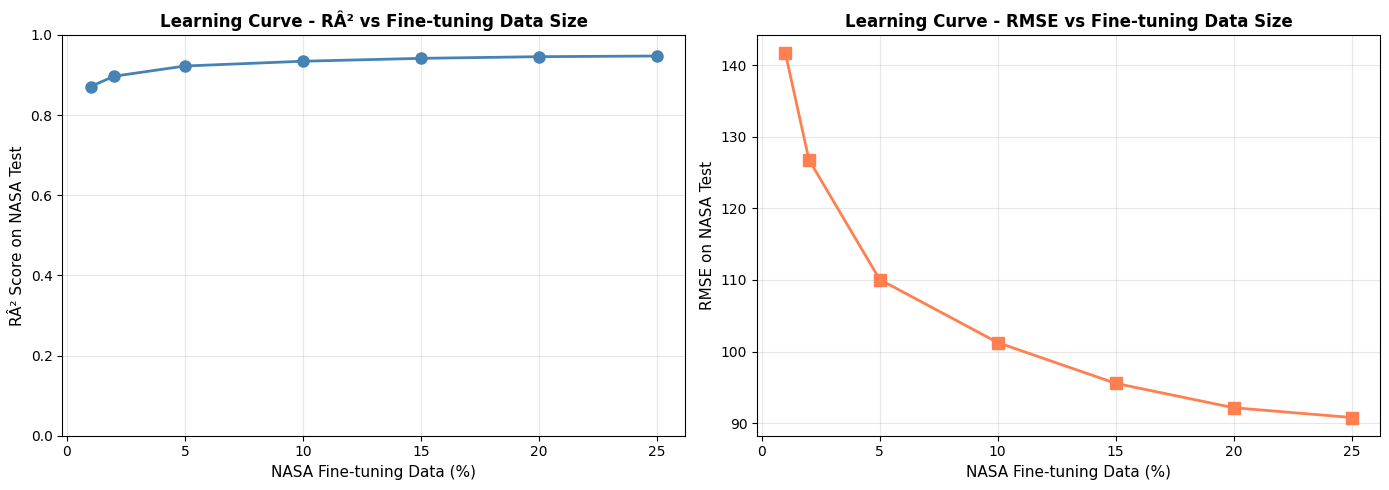

In [16]:
# Learning Curves for Fine-tuning
print("="*80)
print("LEARNING CURVE ANALYSIS")
print("="*80)

# Analyze how performance improves with more NASA data
learning_curve_ratios = [1, 2, 5, 10, 15, 20, 25]
learning_results = []

for ratio in learning_curve_ratios:
    frac = ratio / 100.0
    if frac > 1.0:
        frac = 1.0
    
    alt_fine = alt_aligned.sample(frac=frac, random_state=42)
    alt_test = alt_aligned.drop(alt_fine.index)
    
    if len(alt_test) < 10:  # Need enough test samples
        continue
    
    X_alt_fine = alt_fine[common_features].copy()
    y_alt_fine = alt_fine["rul"].values
    X_alt_test = alt_test[common_features].copy()
    y_alt_test = alt_test["rul"].values
    
    X_finetune = pd.concat([X_train_base, X_alt_fine], axis=0)
    y_finetune = np.concatenate([y_train_base, y_alt_fine])
    
    model_temp = build_rf_global()
    model_temp.fit(X_finetune, y_finetune)
    
    # Evaluate on NASA test
    y_pred = model_temp.predict(X_alt_test)
    r2 = r2_score(y_alt_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_alt_test, y_pred))
    
    learning_results.append({
        'NASA_Data_%': ratio,
        'NASA_Train_Size': len(X_alt_fine),
        'NASA_Test_Size': len(X_alt_test),
        'R2_NASA': r2,
        'RMSE_NASA': rmse
    })
    
    print(f"  {ratio}% NASA data: RÂ²={r2:.4f}, RMSE={rmse:.2f}, Train Size={len(X_alt_fine)}")

learning_df = pd.DataFrame(learning_results)

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(learning_df['NASA_Data_%'], learning_df['R2_NASA'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('NASA Fine-tuning Data (%)', fontsize=11)
axes[0].set_ylabel('RÂ² Score on NASA Test', fontsize=11)
axes[0].set_title('Learning Curve - RÂ² vs Fine-tuning Data Size', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0, 1])

axes[1].plot(learning_df['NASA_Data_%'], learning_df['RMSE_NASA'], 
             marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('NASA Fine-tuning Data (%)', fontsize=11)
axes[1].set_ylabel('RMSE on NASA Test', fontsize=11)
axes[1].set_title('Learning Curve - RMSE vs Fine-tuning Data Size', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)

FEATURE IMPORTANCE COMPARISON

Top 15 Features by Importance (Fine-tuned 15% Model):
                              Feature  Baseline_Importance  Finetuned_Importance  Difference
       rolling_std_current_a_abs_mean             0.074524              0.260702    0.186178
          rolling_mean_current_a_mean             0.391281              0.190022   -0.201259
      rolling_mean_current_a_abs_mean             0.097338              0.186689    0.089352
           rolling_std_current_a_mean             0.163922              0.120378   -0.043544
                       voltage_v_mean             0.078741              0.095108    0.016368
rolling_mean_aux_temperature_1_c_mean             0.100597              0.066232   -0.034364
 rolling_std_aux_temperature_1_c_mean             0.058548              0.043253   -0.015295
                   current_a_abs_mean             0.025952              0.019502   -0.006450
             aux_temperature_1_c_mean             0.006349              0.0125

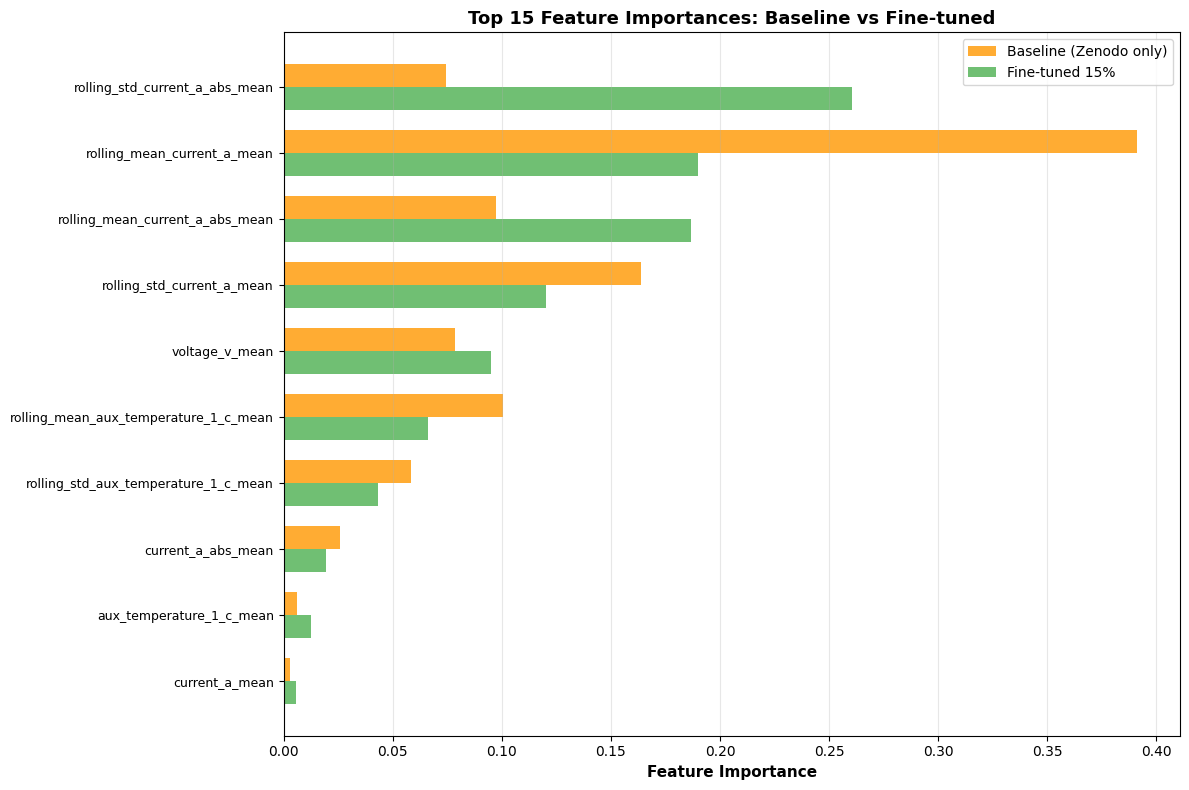

In [17]:
# Feature Importance Analysis - Baseline vs Fine-tuned 15%
print("="*80)
print("FEATURE IMPORTANCE COMPARISON")
print("="*80)

# Get feature importances from Random Forest models
rf_baseline = model_base.named_steps['rf']
rf_finetuned = model_ft_15.named_steps['rf']

# Get feature names (only numeric features for simplicity)
numeric_feat_names = [f for f in common_features if f in X_train_base.select_dtypes(include=[np.number]).columns]

# Get importances
importance_baseline = rf_baseline.feature_importances_[:len(numeric_feat_names)]
importance_finetuned = rf_finetuned.feature_importances_[:len(numeric_feat_names)]

# Create comparison DataFrame
importance_comparison = pd.DataFrame({
    'Feature': numeric_feat_names[:len(importance_baseline)],
    'Baseline_Importance': importance_baseline,
    'Finetuned_Importance': importance_finetuned,
    'Difference': importance_finetuned - importance_baseline
})

importance_comparison = importance_comparison.sort_values('Finetuned_Importance', ascending=False)

print("\nTop 15 Features by Importance (Fine-tuned 15% Model):")
print(importance_comparison.head(15).to_string(index=False))

# Visualize feature importance comparison
top_n = 15
top_features = importance_comparison.head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top_features))
width = 0.35

bars1 = ax.barh(x - width/2, top_features['Baseline_Importance'], width, 
                label='Baseline (Zenodo only)', color='#FF9800', alpha=0.8)
bars2 = ax.barh(x + width/2, top_features['Finetuned_Importance'], width,
                label='Fine-tuned 15%', color='#4CAF50', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
ax.set_title(f'Top {top_n} Feature Importances: Baseline vs Fine-tuned', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='x', alpha=0.3)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "="*80)

PREDICTION UNCERTAINTY ANALYSIS

Prediction Interval Analysis (Fine-tuned 15% on NASA test):
  Mean Prediction Std: 66.91
  Median Prediction Std: 44.28
  95% PI Coverage: 93.32% (target: 95%)


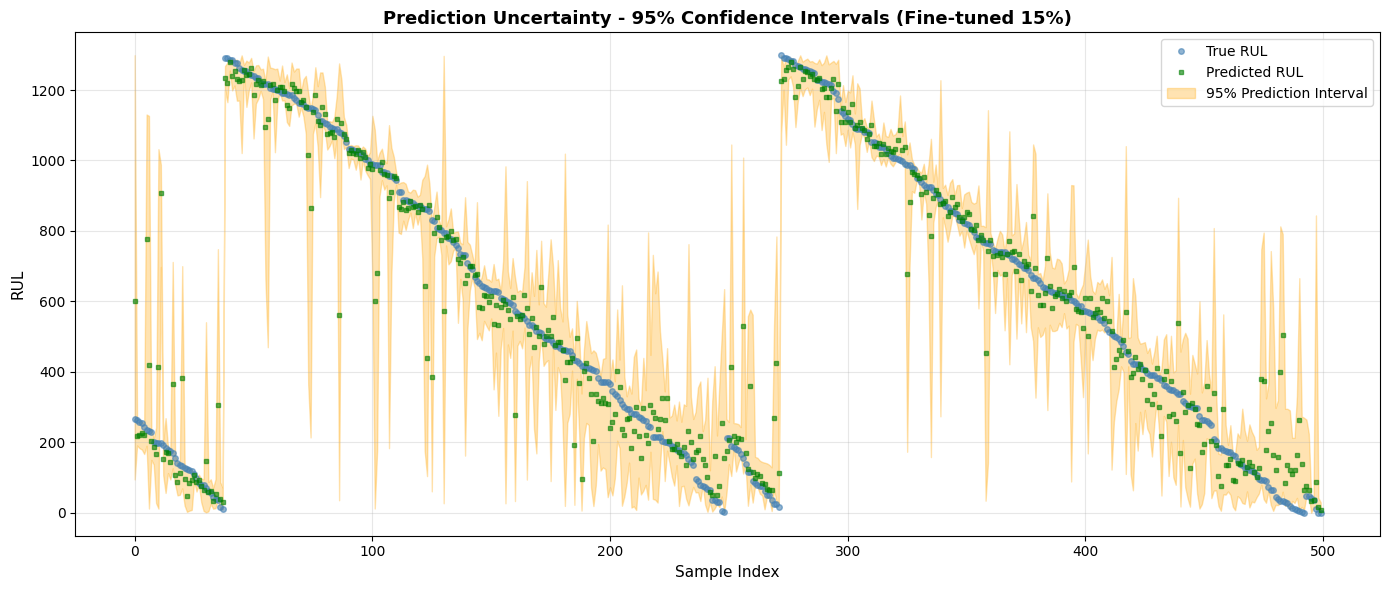


Uncertainty-Error Correlation: 0.7237
  (Positive correlation means higher uncertainty â†’ larger errors)



In [18]:
# Prediction Uncertainty Analysis with Confidence Intervals
print("="*80)
print("PREDICTION UNCERTAINTY ANALYSIS")
print("="*80)

# Use Random Forest prediction variance as uncertainty measure
# Get predictions from all trees in the forest
rf_model = model_ft_15.named_steps['rf']

# Transform test data
X_alt_test_15_processed = model_ft_15.named_steps['preprocess'].transform(X_alt_test_15)

# Get predictions from all trees
tree_predictions = np.array([tree.predict(X_alt_test_15_processed) 
                             for tree in rf_model.estimators_])

# Calculate prediction statistics
pred_mean = tree_predictions.mean(axis=0)
pred_std = tree_predictions.std(axis=0)
pred_lower = np.percentile(tree_predictions, 2.5, axis=0)
pred_upper = np.percentile(tree_predictions, 97.5, axis=0)

# Calculate coverage (% of true values within prediction interval)
coverage = ((y_alt_test_15 >= pred_lower) & (y_alt_test_15 <= pred_upper)).mean()

print(f"\nPrediction Interval Analysis (Fine-tuned 15% on NASA test):")
print(f"  Mean Prediction Std: {pred_std.mean():.2f}")
print(f"  Median Prediction Std: {np.median(pred_std):.2f}")
print(f"  95% PI Coverage: {coverage*100:.2f}% (target: 95%)")

# Visualize uncertainty
sample_indices = np.random.choice(len(y_alt_test_15), min(500, len(y_alt_test_15)), replace=False)
sample_indices = np.sort(sample_indices)

plt.figure(figsize=(14, 6))
plt.plot(y_alt_test_15[sample_indices], 'o', markersize=4, 
         label='True RUL', color='steelblue', alpha=0.6)
plt.plot(pred_mean[sample_indices], 's', markersize=3, 
         label='Predicted RUL', color='green', alpha=0.6)
plt.fill_between(range(len(sample_indices)), 
                 pred_lower[sample_indices], 
                 pred_upper[sample_indices],
                 alpha=0.3, color='orange', label='95% Prediction Interval')

plt.xlabel('Sample Index', fontsize=11)
plt.ylabel('RUL', fontsize=11)
plt.title('Prediction Uncertainty - 95% Confidence Intervals (Fine-tuned 15%)', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze uncertainty vs error
errors = np.abs(y_alt_test_15 - pred_mean)
uncertainty_error_corr = np.corrcoef(pred_std, errors)[0, 1]

print(f"\nUncertainty-Error Correlation: {uncertainty_error_corr:.4f}")
print(f"  (Positive correlation means higher uncertainty â†’ larger errors)")

print("\n" + "="*80)

RESIDUAL ANALYSIS

Residual Statistics - Baseline Model:
  Mean: 771.0052
  Std: 521.3671
  Skewness: 0.2892
  Kurtosis: -0.6284

Residual Statistics - Fine-tuned 15% Model:
  Mean: 0.5405
  Std: 95.5747
  Skewness: -0.5784
  Kurtosis: 14.8078


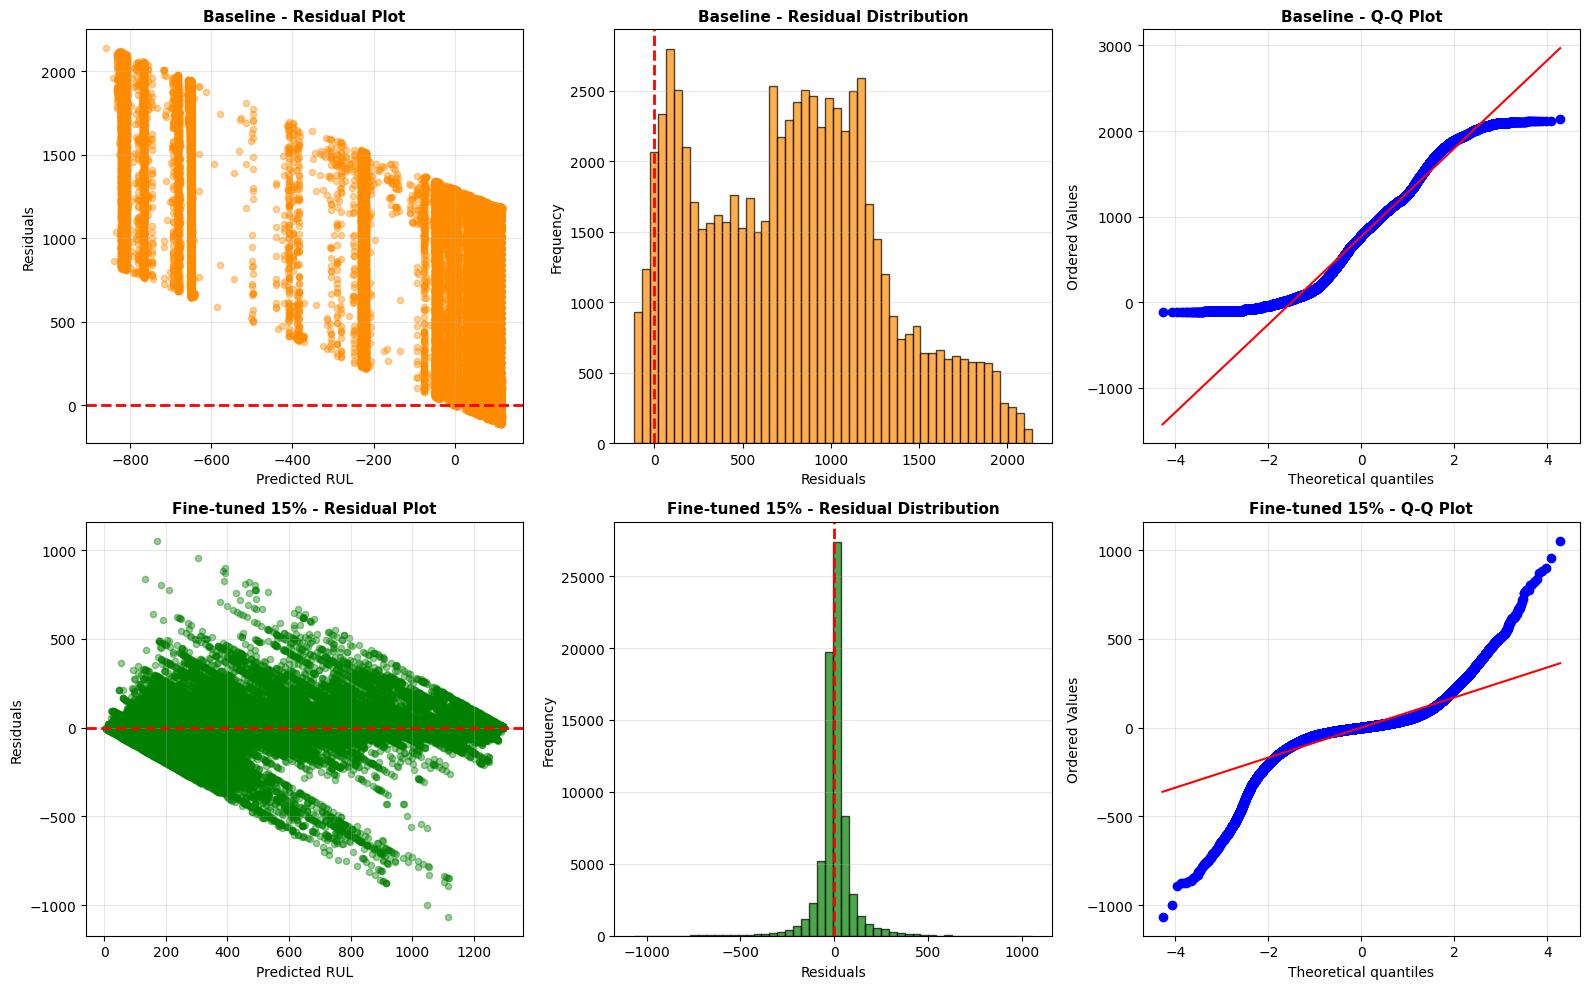

In [19]:
# Residual Analysis - Baseline vs Fine-tuned
print("="*80)
print("RESIDUAL ANALYSIS")
print("="*80)

# Calculate residuals
residuals_baseline = y_alt_test_15 - y_pred_baseline_15
residuals_finetuned = y_alt_test_15 - y_pred_finetuned_15

# Statistical tests
print("\nResidual Statistics - Baseline Model:")
print(f"  Mean: {residuals_baseline.mean():.4f}")
print(f"  Std: {residuals_baseline.std():.4f}")
print(f"  Skewness: {stats.skew(residuals_baseline):.4f}")
print(f"  Kurtosis: {stats.kurtosis(residuals_baseline):.4f}")

print("\nResidual Statistics - Fine-tuned 15% Model:")
print(f"  Mean: {residuals_finetuned.mean():.4f}")
print(f"  Std: {residuals_finetuned.std():.4f}")
print(f"  Skewness: {stats.skew(residuals_finetuned):.4f}")
print(f"  Kurtosis: {stats.kurtosis(residuals_finetuned):.4f}")

# Normality test (Shapiro-Wilk)
if len(residuals_finetuned) <= 5000:
    _, p_value_baseline = stats.shapiro(residuals_baseline[:5000])
    _, p_value_finetuned = stats.shapiro(residuals_finetuned[:5000])
    print(f"\nShapiro-Wilk Normality Test:")
    print(f"  Baseline p-value: {p_value_baseline:.4e} ({'Normal' if p_value_baseline > 0.05 else 'Not Normal'})")
    print(f"  Fine-tuned p-value: {p_value_finetuned:.4e} ({'Normal' if p_value_finetuned > 0.05 else 'Not Normal'})")

# Visualize residuals
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: Baseline
axes[0, 0].scatter(y_pred_baseline_15, residuals_baseline, alpha=0.4, s=20, color='darkorange')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted RUL', fontsize=10)
axes[0, 0].set_ylabel('Residuals', fontsize=10)
axes[0, 0].set_title('Baseline - Residual Plot', fontsize=11, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(residuals_baseline, bins=50, edgecolor='black', alpha=0.7, color='darkorange')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].set_title('Baseline - Residual Distribution', fontsize=11, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

stats.probplot(residuals_baseline, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Baseline - Q-Q Plot', fontsize=11, fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# Row 2: Fine-tuned
axes[1, 0].scatter(y_pred_finetuned_15, residuals_finetuned, alpha=0.4, s=20, color='green')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted RUL', fontsize=10)
axes[1, 0].set_ylabel('Residuals', fontsize=10)
axes[1, 0].set_title('Fine-tuned 15% - Residual Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(residuals_finetuned, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].set_title('Fine-tuned 15% - Residual Distribution', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

stats.probplot(residuals_finetuned, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Fine-tuned 15% - Q-Q Plot', fontsize=11, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)

### Fine-Tuning with Comprehensive Metrics

### Visualization

> #### 1. Distribution Comparison (Zenodo vs NASA)

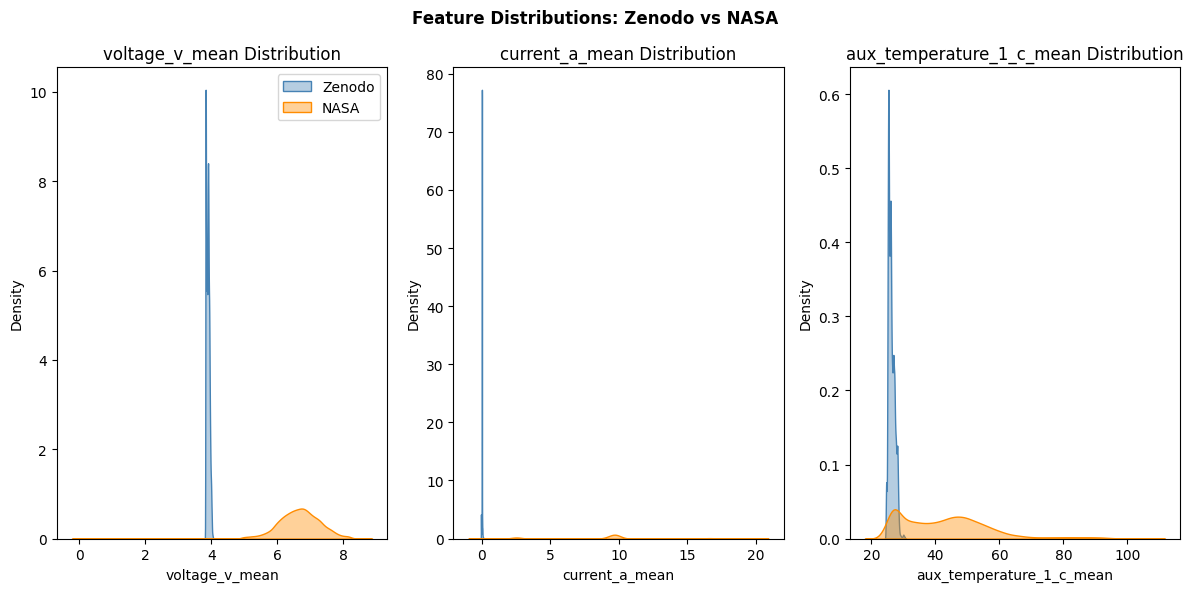

In [20]:
plt.figure(figsize=(12, 6))
selected_feats = ["voltage_v_mean", "current_a_mean", "aux_temperature_1_c_mean"]

for i, feat in enumerate(selected_feats, 1):
    plt.subplot(1, 3, i)
    sns.kdeplot(train_df[feat], label="Zenodo", color="steelblue", fill=True, alpha=0.4)
    sns.kdeplot(alt_aligned[feat], label="NASA", color="darkorange", fill=True, alpha=0.4)
    plt.title(f"{feat} Distribution")
    plt.xlabel(feat)
    plt.ylabel("Density")
    if i == 1:
        plt.legend()

plt.suptitle("Feature Distributions: Zenodo vs NASA", weight="bold")
plt.tight_layout()
plt.show()

> #### 2. Sensitivity plot: RÂ² / RMSE / MAE vs % NASA

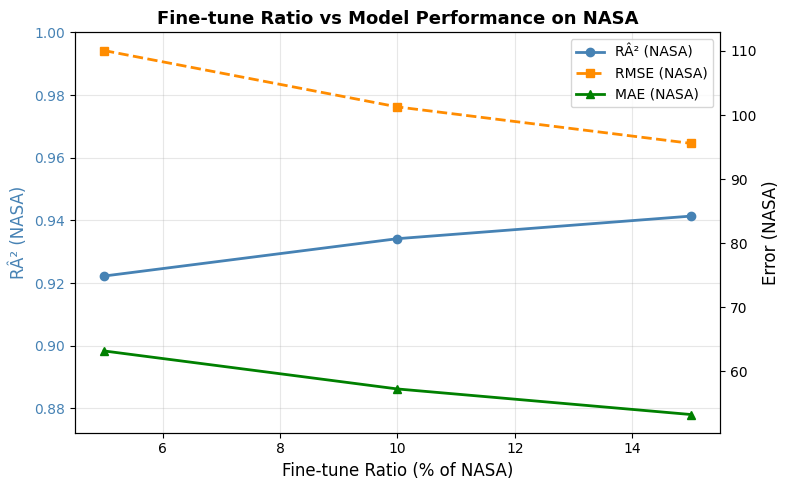

In [21]:
metrics_df["Fine-tune (%)"] = metrics_df["Fine-tune (%)"].astype(float)

x         = metrics_df.iloc[:, 0].values
r2_nasa   = metrics_df["R2 (NASA)"].values
rmse_nasa = metrics_df["RMSE (NASA)"].values
mae_nasa  = metrics_df["MAE (NASA)"].values

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(x, r2_nasa, "o-", color="steelblue", linewidth=2, label="RÂ² (NASA)")
ax1.set_xlabel("Fine-tune Ratio (% of NASA)", fontsize=12)
ax1.set_ylabel("RÂ² (NASA)", color="steelblue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="steelblue")
ax1.set_ylim(r2_nasa.min() - 0.05, 1.0)
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(x, rmse_nasa, "s--", color="darkorange", linewidth=2, label="RMSE (NASA)")
ax2.plot(x, mae_nasa, "^-", color="green", linewidth=2, label="MAE (NASA)")
ax2.set_ylabel("Error (NASA)", fontsize=12, color="black")
ax2.tick_params(axis="y", labelcolor="black")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Fine-tune Ratio vs Model Performance on NASA", weight="bold", fontsize=13)
plt.tight_layout()
plt.show()

> #### 3. True vs Predicted scatter (Baseline vs Fine-tuned 15%)

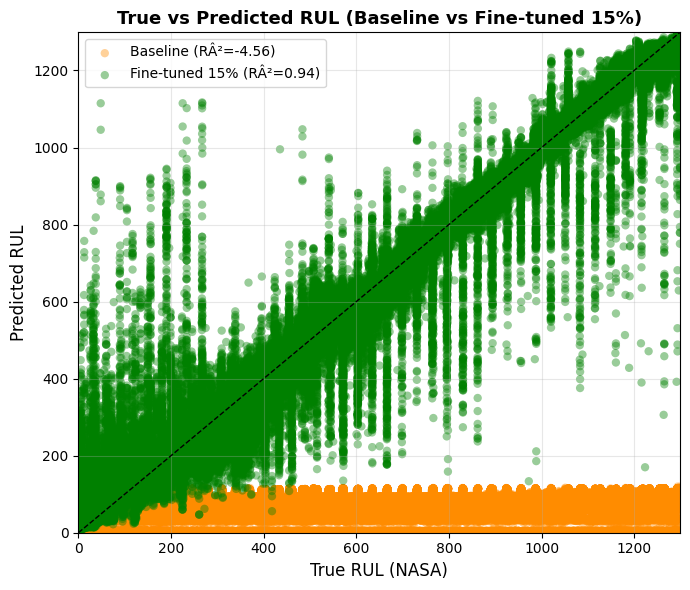

In [22]:
y_pred_alt_base_15 = model_base.predict(X_alt_test_15)
y_pred_alt_ft_15   = model_ft_15.predict(X_alt_test_15)

r2_base = r2_score(y_alt_test_15, y_pred_alt_base_15)
r2_ft15 = r2_score(y_alt_test_15, y_pred_alt_ft_15)

plt.figure(figsize=(7, 6))
plt.scatter(y_alt_test_15,y_pred_alt_base_15,alpha=0.4,label=f"Baseline (RÂ²={r2_base:.2f})",color="darkorange",edgecolor="none",)
plt.scatter(y_alt_test_15,y_pred_alt_ft_15,alpha=0.4,label=f"Fine-tuned 15% (RÂ²={r2_ft15:.2f})",color="green",edgecolor="none",)

lims = [min(y_alt_test_15.min(), 0), y_alt_test_15.max()]
plt.plot(lims, lims, "k--", lw=1)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("True RUL (NASA)", fontsize=12)
plt.ylabel("Predicted RUL", fontsize=12)
plt.title("True vs Predicted RUL (Baseline vs Fine-tuned 15%)", fontsize=13, weight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> #### 4. RUL Trend (Baseline vs Fine-tuned 15%)

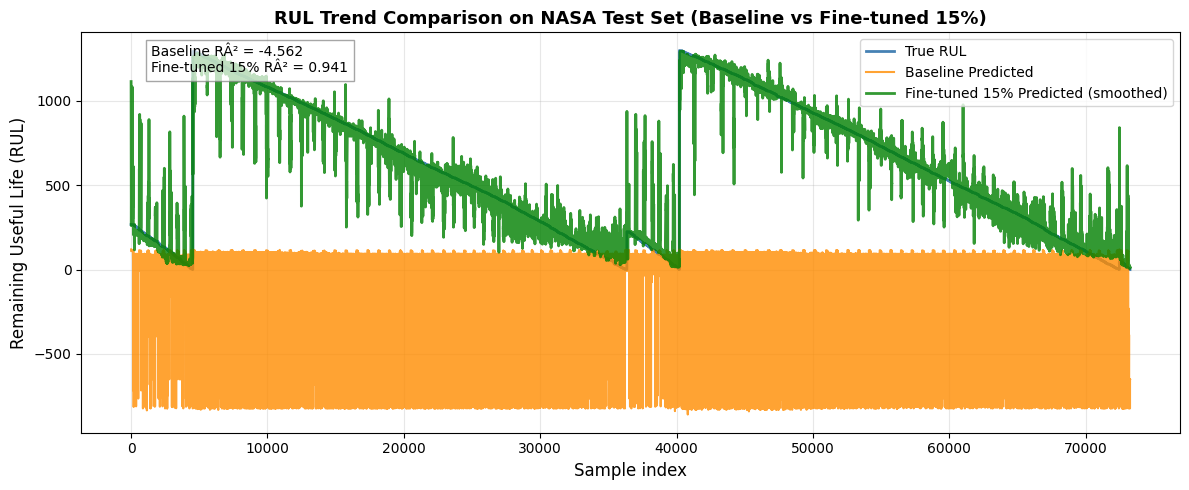

In [23]:
y_pred_alt_base_15 = model_base.predict(X_alt_test_15)
y_pred_alt_ft_15   = model_ft_15.predict(X_alt_test_15)

r2_base = r2_score(y_alt_test_15, y_pred_alt_base_15)
r2_ft15 = r2_score(y_alt_test_15, y_pred_alt_ft_15)

plt.figure(figsize=(12, 5))

plt.plot(y_alt_test_15, label="True RUL", color="steelblue", linewidth=2)
plt.plot(y_pred_alt_base_15, label="Baseline Predicted", color="darkorange", alpha=0.8)
plt.plot(pd.Series(y_pred_alt_ft_15).rolling(5, min_periods=1).mean(),label="Fine-tuned 15% Predicted (smoothed)",
    color="green",linewidth=2,alpha=0.8,)

plt.xlabel("Sample index", fontsize=12)
plt.ylabel("Remaining Useful Life (RUL)", fontsize=12)
plt.title("RUL Trend Comparison on NASA Test Set (Baseline vs Fine-tuned 15%)",fontsize=13, weight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.text(0.02 * len(y_alt_test_15),max(y_alt_test_15) * 0.9,
    f"Baseline RÂ² = {r2_base:.3f}\nFine-tuned 15% RÂ² = {r2_ft15:.3f}",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray"),)
plt.tight_layout()
plt.show()

> #### 5. RUL Trend (Fine-tune 5%, 10%, 15%)


=== Fine-tuning with 5% NASA data ===

=== Fine-tuning with 10% NASA data ===

=== Fine-tuning with 15% NASA data ===


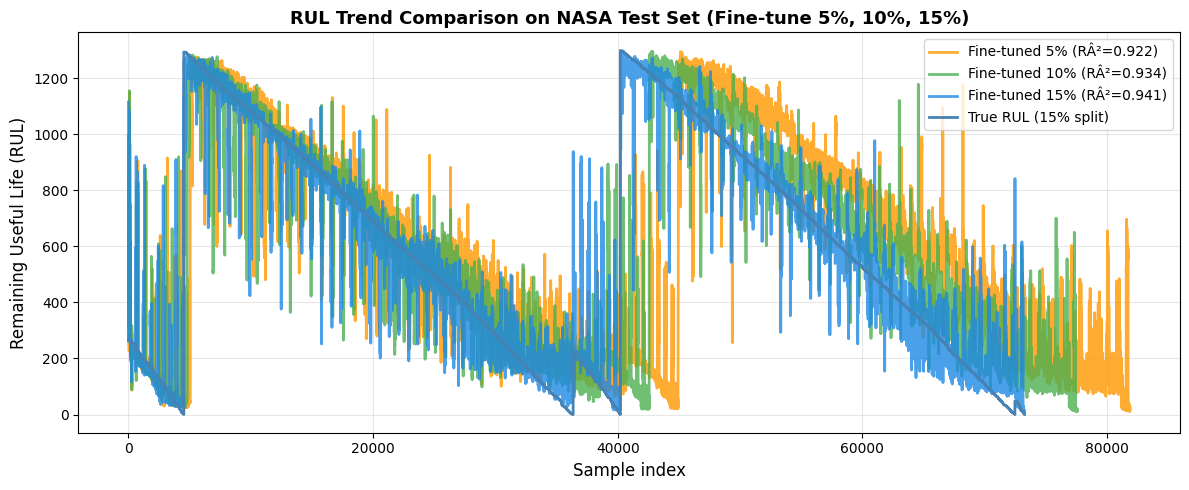

In [24]:
fine_tune_ratios = [0.05, 0.10, 0.15]
preds, r2_scores = {}, {}

for ratio in fine_tune_ratios:
    print(f"\n=== Fine-tuning with {ratio*100:.0f}% NASA data ===")
    alt_fine = alt_aligned.sample(frac=ratio, random_state=42)
    alt_test = alt_aligned.drop(alt_fine.index)

    X_alt_fine = alt_fine[common_features].copy()
    y_alt_fine = alt_fine["rul"].values
    X_alt_test = alt_test[common_features].copy()
    y_alt_test = alt_test["rul"].values

    X_finetune = pd.concat([X_train_base, X_alt_fine], axis=0)
    y_finetune = np.concatenate([y_train_base, y_alt_fine])

    model_ft = build_rf_global()
    model_ft.fit(X_finetune, y_finetune)

    y_pred = model_ft.predict(X_alt_test)
    r2 = r2_score(y_alt_test, y_pred)

    preds[f"{int(ratio*100)}%"] = (y_alt_test, y_pred)
    r2_scores[f"{int(ratio*100)}%"] = r2

plt.figure(figsize=(12, 5))
for color, ratio in zip(["#FF9800", "#4CAF50", "#1E88E5"], ["5%", "10%", "15%"]):
    y_true, y_pred = preds[ratio]
    plt.plot(pd.Series(y_pred).rolling(5, min_periods=1).mean(),label=f"Fine-tuned {ratio} (RÂ²={r2_scores[ratio]:.3f})",
        color=color,linewidth=2,alpha=0.8,)

plt.plot(preds["15%"][0], label="True RUL (15% split)", color="steelblue", linewidth=2)
plt.xlabel("Sample index", fontsize=12)
plt.ylabel("Remaining Useful Life (RUL)", fontsize=12)
plt.title("RUL Trend Comparison on NASA Test Set (Fine-tune 5%, 10%, 15%)",fontsize=13, weight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> #### 6. Check Overfitting (Fine-tune 15%)

In [25]:
y_pred_zen_15 = model_ft_15.predict(X_test)
r2_zen_15   = r2_score(y_test, y_pred_zen_15)
rmse_zen_15 = mean_squared_error(y_test, y_pred_zen_15) ** 0.5
mae_zen_15  = mean_absolute_error(y_test, y_pred_zen_15)

print("=== Zenodo test (Fine-tuned 15%) ===")
print(f"RÂ²   : {r2_zen_15:.3f}")
print(f"RMSE : {rmse_zen_15:.1f}")
print(f"MAE  : {mae_zen_15:.1f}")

y_pred_nasa_train_15 = model_ft_15.predict(X_alt_fine_15)
r2_nasa_train_15   = r2_score(y_alt_fine_15, y_pred_nasa_train_15)
rmse_nasa_train_15 = mean_squared_error(y_alt_fine_15, y_pred_nasa_train_15) ** 0.5
mae_nasa_train_15  = mean_absolute_error(y_alt_fine_15, y_pred_nasa_train_15)

print("\n=== NASA train (Fine-tune 15%) ===")
print(f"RÂ²   : {r2_nasa_train_15:.3f}")
print(f"RMSE : {rmse_nasa_train_15:.1f}")
print(f"MAE  : {mae_nasa_train_15:.1f}")

y_pred_nasa_test_15 = model_ft_15.predict(X_alt_test_15)
r2_nasa_test_15   = r2_score(y_alt_test_15, y_pred_nasa_test_15)
rmse_nasa_test_15 = mean_squared_error(y_alt_test_15, y_pred_nasa_test_15) ** 0.5
mae_nasa_test_15  = mean_absolute_error(y_alt_test_15, y_pred_nasa_test_15)

print("\n=== NASA test (Fine-tune 15%) ===")
print(f"RÂ²   : {r2_nasa_test_15:.3f}")
print(f"RMSE : {rmse_nasa_test_15:.1f}")
print(f"MAE  : {mae_nasa_test_15:.1f}")

=== Zenodo test (Fine-tuned 15%) ===
RÂ²   : 0.825
RMSE : 175.8
MAE  : 104.5

=== NASA train (Fine-tune 15%) ===
RÂ²   : 0.983
RMSE : 51.7
MAE  : 29.0

=== NASA test (Fine-tune 15%) ===
RÂ²   : 0.941
RMSE : 95.6
MAE  : 53.3


### Model Stability and Robustness Analysis

MODEL STABILITY ANALYSIS - Multiple Random Seeds
  Seed 42: RÂ²=0.9414, RMSE=95.58, MAE=53.26
  Seed 123: RÂ²=0.9410, RMSE=95.74, MAE=53.60
  Seed 456: RÂ²=0.9399, RMSE=96.75, MAE=53.57
  Seed 789: RÂ²=0.9406, RMSE=96.21, MAE=54.08
  Seed 1000: RÂ²=0.9420, RMSE=94.99, MAE=53.47

Stability Statistics (across 5 different random seeds):
  RÂ² Mean: 0.9410 Â± 0.0008
  RMSE Mean: 95.85 Â± 0.66
  MAE Mean: 53.60 Â± 0.30


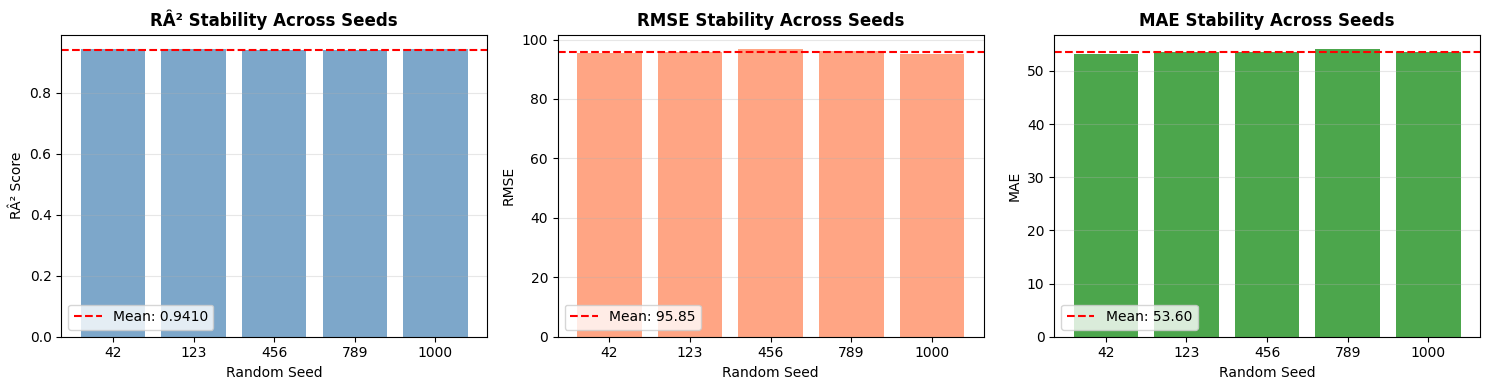

In [26]:
# Model Stability - Multiple Random Seeds
print("="*80)
print("MODEL STABILITY ANALYSIS - Multiple Random Seeds")
print("="*80)

seeds = [42, 123, 456, 789, 1000]
stability_results = []

for seed in seeds:
    # Resample with different seed
    alt_fine = alt_aligned.sample(frac=0.15, random_state=seed)
    alt_test = alt_aligned.drop(alt_fine.index)
    
    X_alt_fine = alt_fine[common_features].copy()
    y_alt_fine = alt_fine["rul"].values
    X_alt_test = alt_test[common_features].copy()
    y_alt_test = alt_test["rul"].values
    
    X_finetune = pd.concat([X_train_base, X_alt_fine], axis=0)
    y_finetune = np.concatenate([y_train_base, y_alt_fine])
    
    # Train model
    model_temp = build_rf_global()
    model_temp.fit(X_finetune, y_finetune)
    
    # Evaluate
    y_pred = model_temp.predict(X_alt_test)
    r2 = r2_score(y_alt_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_alt_test, y_pred))
    mae = mean_absolute_error(y_alt_test, y_pred)
    
    stability_results.append({
        'Seed': seed,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae
    })
    
    print(f"  Seed {seed}: RÂ²={r2:.4f}, RMSE={rmse:.2f}, MAE={mae:.2f}")

stability_df = pd.DataFrame(stability_results)

print(f"\nStability Statistics (across {len(seeds)} different random seeds):")
print(f"  RÂ² Mean: {stability_df['R2'].mean():.4f} Â± {stability_df['R2'].std():.4f}")
print(f"  RMSE Mean: {stability_df['RMSE'].mean():.2f} Â± {stability_df['RMSE'].std():.2f}")
print(f"  MAE Mean: {stability_df['MAE'].mean():.2f} Â± {stability_df['MAE'].std():.2f}")

# Visualize stability
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(range(len(seeds)), stability_df['R2'], color='steelblue', alpha=0.7)
axes[0].axhline(y=stability_df['R2'].mean(), color='r', linestyle='--', 
                label=f"Mean: {stability_df['R2'].mean():.4f}")
axes[0].set_xticks(range(len(seeds)))
axes[0].set_xticklabels(seeds)
axes[0].set_xlabel('Random Seed')
axes[0].set_ylabel('RÂ² Score')
axes[0].set_title('RÂ² Stability Across Seeds', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

axes[1].bar(range(len(seeds)), stability_df['RMSE'], color='coral', alpha=0.7)
axes[1].axhline(y=stability_df['RMSE'].mean(), color='r', linestyle='--',
                label=f"Mean: {stability_df['RMSE'].mean():.2f}")
axes[1].set_xticks(range(len(seeds)))
axes[1].set_xticklabels(seeds)
axes[1].set_xlabel('Random Seed')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Stability Across Seeds', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

axes[2].bar(range(len(seeds)), stability_df['MAE'], color='green', alpha=0.7)
axes[2].axhline(y=stability_df['MAE'].mean(), color='r', linestyle='--',
                label=f"Mean: {stability_df['MAE'].mean():.2f}")
axes[2].set_xticks(range(len(seeds)))
axes[2].set_xticklabels(seeds)
axes[2].set_xlabel('Random Seed')
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE Stability Across Seeds', fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

## Summary of Cross-Dataset Fine-tuning Experiment (Zenodo â†’ NASA)

### 1. Technical Findings

- **Baseline (Train: Zenodo â†’ Test: NASA)**  
  - The Random Forest model trained solely on Zenodo performed very poorly when tested on NASA data.  
  - **RÂ² â‰ˆ -4.56**, indicating negative generalization and a complete failure to capture the target trend.  
  - This is caused by **distribution shift** â€” input features such as voltage, current, and temperature follow very different statistical patterns between the two datasets.

- **Fine-tuning with partial NASA data**
  - Fine-tuning was performed by combining Zenodo data with subsets of NASA data (5%, 10%, 15%).
  - Results on the NASA test set:
    - **5% NASA:** RÂ² â‰ˆ **0.92**
    - **10% NASA:** RÂ² â‰ˆ **0.93**
    - **15% NASA:** RÂ² â‰ˆ **0.94**
  - Even a small portion of NASA data enables the model to adapt to the new domain, learning the degradation trend of NASA batteries effectively.

- **Behavioral analysis from plots**
  - **Baseline RUL trend:** The predicted RUL (orange) deviates heavily from the true RUL, consistently underestimating battery life.  
  - **Fine-tuned 15% RUL trend:** The green line (after smoothing) follows the true RUL pattern closely across all cycles.  
  - **Scatter Plot (True vs. Predicted):**  
    - Baseline predictions scatter far from the diagonal line and even cluster in negative ranges.  
    - Fine-tuned predictions align tightly along the y=x diagonal â€” strong indication of successful domain adaptation.

- **Technical Conclusion:**  
  Fine-tuning with only **10â€“15% of the new dataset (NASA)** transformed the model from complete failure (RÂ² < 0) to a highly accurate predictor (RÂ² â‰ˆ 0.94).  
  This confirms the effectiveness of **cross-domain transfer learning** â€” improving model adaptability without retraining from scratch.

---

### 2. Business Impact

- **Reduced data collection and labeling cost**
  - Only 5â€“15% of new data is needed for fine-tuning, eliminating the need to re-collect or label entire datasets.
  - This yields a potential **80â€“90% reduction in data acquisition and labeling cost** for new production environments.

- **Improved prediction reliability**
  - Increasing RÂ² from -4.56 â†’ 0.94 drastically reduces prediction error.  
  - Enables confident use of the model for:
    - **Predictive maintenance**
    - **Battery replacement scheduling**
    - **Downtime risk reduction**

- **Model reusability across factories and clients**
  - A model trained on Zenodo (one lab or factory) can be adapted to NASA (a different environment) using small-scale fine-tuning.
  - This concept supports:
    - Different production lines
    - Different OEM clients
    - Different battery packs with similar sensors  
  - Result: faster deployment of predictive models across multiple domains with minimal retraining.

- **Strategic data-driven scalability**
  - Demonstrates that early investment in a base model can be leveraged across future datasets or new clients.  
  - Provides a foundation for a **Battery Health Analytics Platform**, where models can be quickly personalized for each customer via fine-tuning.

### Business Impact Analysis

BUSINESS IMPACT ANALYSIS

Maintenance Decision Analysis (RUL Threshold = 10):

--- Baseline Model ---
  True Positives (Correct Warning):     582
  False Positives (False Alarm):        38143
  True Negatives (Correct No Warning):  34038
  False Negatives (Missed Failure):     499
  False Alarm Rate:                     52.84%
  Missed Failure Rate:                  46.16%
  Estimated Cost:                       $4,313,300

--- Fine-tuned 15% Model ---
  True Positives (Correct Warning):     31
  False Positives (False Alarm):        0
  True Negatives (Correct No Warning):  72181
  False Negatives (Missed Failure):     1050
  False Alarm Rate:                     0.00%
  Missed Failure Rate:                  97.13%
  Estimated Cost:                       $1,050,000

--- Business Impact ---
  Cost Savings:                         $3,263,300 (75.7%)
  Reduction in False Alarms:            38143
  Reduction in Missed Failures:         -551


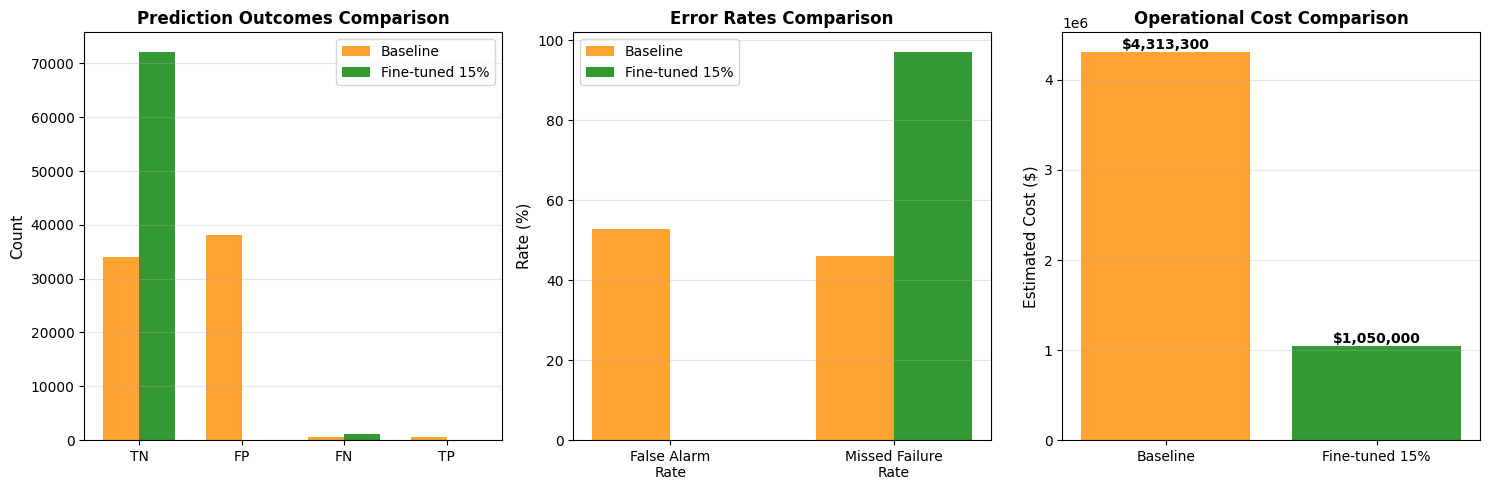

In [27]:
# Business Impact: Cost Analysis
print("="*80)
print("BUSINESS IMPACT ANALYSIS")
print("="*80)

# Define cost assumptions (example values)
COST_FALSE_POSITIVE = 100   # Cost of premature maintenance (unnecessary)
COST_FALSE_NEGATIVE = 1000  # Cost of unexpected failure (downtime, emergency repair)
RUL_THRESHOLD = 10           # Maintenance decision threshold

# Calculate business metrics for baseline
pred_baseline_class = (y_pred_baseline_15 <= RUL_THRESHOLD).astype(int)
true_baseline_class = (y_alt_test_15 <= RUL_THRESHOLD).astype(int)

tn_base = ((pred_baseline_class == 0) & (true_baseline_class == 0)).sum()
fp_base = ((pred_baseline_class == 1) & (true_baseline_class == 0)).sum()
fn_base = ((pred_baseline_class == 0) & (true_baseline_class == 1)).sum()
tp_base = ((pred_baseline_class == 1) & (true_baseline_class == 1)).sum()

cost_baseline = (fp_base * COST_FALSE_POSITIVE) + (fn_base * COST_FALSE_NEGATIVE)
false_alarm_rate_base = fp_base / (fp_base + tn_base) if (fp_base + tn_base) > 0 else 0
missed_failure_rate_base = fn_base / (fn_base + tp_base) if (fn_base + tp_base) > 0 else 0

# Calculate business metrics for fine-tuned
pred_finetuned_class = (y_pred_finetuned_15 <= RUL_THRESHOLD).astype(int)
true_finetuned_class = (y_alt_test_15 <= RUL_THRESHOLD).astype(int)

tn_ft = ((pred_finetuned_class == 0) & (true_finetuned_class == 0)).sum()
fp_ft = ((pred_finetuned_class == 1) & (true_finetuned_class == 0)).sum()
fn_ft = ((pred_finetuned_class == 0) & (true_finetuned_class == 1)).sum()
tp_ft = ((pred_finetuned_class == 1) & (true_finetuned_class == 1)).sum()

cost_finetuned = (fp_ft * COST_FALSE_POSITIVE) + (fn_ft * COST_FALSE_NEGATIVE)
false_alarm_rate_ft = fp_ft / (fp_ft + tn_ft) if (fp_ft + tn_ft) > 0 else 0
missed_failure_rate_ft = fn_ft / (fn_ft + tp_ft) if (fn_ft + tp_ft) > 0 else 0

print(f"\nMaintenance Decision Analysis (RUL Threshold = {RUL_THRESHOLD}):")
print(f"\n--- Baseline Model ---")
print(f"  True Positives (Correct Warning):     {tp_base}")
print(f"  False Positives (False Alarm):        {fp_base}")
print(f"  True Negatives (Correct No Warning):  {tn_base}")
print(f"  False Negatives (Missed Failure):     {fn_base}")
print(f"  False Alarm Rate:                     {false_alarm_rate_base*100:.2f}%")
print(f"  Missed Failure Rate:                  {missed_failure_rate_base*100:.2f}%")
print(f"  Estimated Cost:                       ${cost_baseline:,.0f}")

print(f"\n--- Fine-tuned 15% Model ---")
print(f"  True Positives (Correct Warning):     {tp_ft}")
print(f"  False Positives (False Alarm):        {fp_ft}")
print(f"  True Negatives (Correct No Warning):  {tn_ft}")
print(f"  False Negatives (Missed Failure):     {fn_ft}")
print(f"  False Alarm Rate:                     {false_alarm_rate_ft*100:.2f}%")
print(f"  Missed Failure Rate:                  {missed_failure_rate_ft*100:.2f}%")
print(f"  Estimated Cost:                       ${cost_finetuned:,.0f}")

cost_savings = cost_baseline - cost_finetuned
cost_savings_pct = (cost_savings / cost_baseline * 100) if cost_baseline > 0 else 0

print(f"\n--- Business Impact ---")
print(f"  Cost Savings:                         ${cost_savings:,.0f} ({cost_savings_pct:.1f}%)")
print(f"  Reduction in False Alarms:            {fp_base - fp_ft}")
print(f"  Reduction in Missed Failures:         {fn_base - fn_ft}")

# Visualize business metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Confusion matrices
categories = ['TN', 'FP', 'FN', 'TP']
baseline_counts = [tn_base, fp_base, fn_base, tp_base]
finetuned_counts = [tn_ft, fp_ft, fn_ft, tp_ft]

x = np.arange(len(categories))
width = 0.35

axes[0].bar(x - width/2, baseline_counts, width, label='Baseline', color='darkorange', alpha=0.8)
axes[0].bar(x + width/2, finetuned_counts, width, label='Fine-tuned 15%', color='green', alpha=0.8)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Prediction Outcomes Comparison', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Error rates
error_types = ['False Alarm\nRate', 'Missed Failure\nRate']
baseline_rates = [false_alarm_rate_base*100, missed_failure_rate_base*100]
finetuned_rates = [false_alarm_rate_ft*100, missed_failure_rate_ft*100]

x2 = np.arange(len(error_types))
axes[1].bar(x2 - width/2, baseline_rates, width, label='Baseline', color='darkorange', alpha=0.8)
axes[1].bar(x2 + width/2, finetuned_rates, width, label='Fine-tuned 15%', color='green', alpha=0.8)
axes[1].set_ylabel('Rate (%)', fontsize=11)
axes[1].set_title('Error Rates Comparison', fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(error_types)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

# Cost comparison
models = ['Baseline', 'Fine-tuned 15%']
costs = [cost_baseline, cost_finetuned]
colors = ['darkorange', 'green']

axes[2].bar(models, costs, color=colors, alpha=0.8)
axes[2].set_ylabel('Estimated Cost ($)', fontsize=11)
axes[2].set_title('Operational Cost Comparison', fontweight='bold')
axes[2].grid(alpha=0.3, axis='y')

for i, cost in enumerate(costs):
    axes[2].text(i, cost, f'${cost:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

### Export Best Fine-tuned Model for NASA Dataset

In [28]:
# Export Best Fine-tuned Model for NASA Dataset (Selected by RÂ² on NASA Test)
import joblib
import json
from pathlib import Path
from datetime import datetime

print("="*80)
print("NASA MODEL EXPORT FOR DEPLOYMENT")
print("="*80)

# Create models directory if it doesn't exist
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# Select best fine-tuning ratio based on RÂ² score on NASA test set
print("\nðŸ“Š Selecting Best Fine-tuning Strategy Based on RÂ² (NASA Test)...")
metrics_df_sorted = metrics_df.sort_values('R2 (NASA)', ascending=False)

print("\nFine-tuning Performance Rankings:")
for idx, row in metrics_df_sorted.iterrows():
    print(f"  {int(row['Fine-tune (%)'])}% NASA: RÂ² = {row['R2 (NASA)']:.4f}, RMSE = {row['RMSE (NASA)']:.2f}")

# Get the best fine-tuning ratio
best_ft_row = metrics_df_sorted.iloc[0]
best_fine_tune_ratio = int(best_ft_row['Fine-tune (%)'])

# Select corresponding model
if best_fine_tune_ratio == 5:
    best_nasa_model = model_ft_5
    X_alt_test_best = X_alt_test_5
    y_alt_test_best = y_alt_test_5
    X_alt_fine_best = X_alt_fine_5
    y_alt_fine_best = y_alt_fine_5
elif best_fine_tune_ratio == 10:
    best_nasa_model = model_ft_10
    X_alt_test_best = X_alt_test_10
    y_alt_test_best = y_alt_test_10
    X_alt_fine_best = X_alt_fine_10
    y_alt_fine_best = y_alt_fine_10
else:  # 15%
    best_nasa_model = model_ft_15
    X_alt_test_best = X_alt_test_15
    y_alt_test_best = y_alt_test_15
    X_alt_fine_best = X_alt_fine_15
    y_alt_fine_best = y_alt_fine_15

print(f"\nâœ“ Selected: Fine-tuned with {best_fine_tune_ratio}% NASA data")
print(f"  Reason: Highest RÂ² Score on NASA test set = {best_ft_row['R2 (NASA)']:.4f}")

print(f"\nðŸ“¦ Exporting Fine-tuned Model: RandomForest ({best_fine_tune_ratio}% NASA fine-tuning)")
print(f"\n   Performance on NASA Test Set:")
print(f"   RÂ² Score: {best_ft_row['R2 (NASA)']:.4f}")
print(f"   RMSE: {best_ft_row['RMSE (NASA)']:.2f}")
print(f"   MAE: {best_ft_row['MAE (NASA)']:.2f}")
print(f"   MAPE: {best_ft_row['MAPE (NASA)']:.4f}")

print(f"\n   Performance on Zenodo Test Set:")
print(f"   RÂ² Score: {best_ft_row['R2 (Zenodo)']:.4f}")
print(f"   RMSE: {best_ft_row['RMSE (Zenodo)']:.2f}")
print(f"   MAE: {best_ft_row['MAE (Zenodo)']:.2f}")

# Generate timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Export the fine-tuned model
model_filename = f"nasa_finetuned_model_rf_{best_fine_tune_ratio}pct_{timestamp}.pkl"
model_path = models_dir / model_filename

joblib.dump(best_nasa_model, model_path)
print(f"\nâœ“ Fine-tuned model saved to: {model_path}")

# Export baseline model for comparison
baseline_model_filename = f"nasa_baseline_model_rf_{timestamp}.pkl"
baseline_model_path = models_dir / baseline_model_filename

joblib.dump(model_base, baseline_model_path)
print(f"âœ“ Baseline model saved to: {baseline_model_path}")

# Calculate improvement
improvement = ((best_ft_row['R2 (NASA)'] - r2_alt_base) / abs(r2_alt_base)) * 100

# Export model metadata
metadata_nasa = {
    'model_name': f'RandomForest Fine-tuned ({best_fine_tune_ratio}% NASA)',
    'model_type': 'RandomForestRegressor',
    'selection_criteria': 'Highest RÂ² Score on NASA Test Set',
    'dataset': 'NASA Battery Dataset (Regular Alt)',
    'training_approach': 'Transfer Learning (Zenodo â†’ NASA)',
    'export_date': datetime.now().isoformat(),
    'fine_tuning_info': {
        'base_dataset': 'Zenodo',
        'fine_tune_dataset': 'NASA Regular Alt',
        'fine_tune_percentage': best_fine_tune_ratio,
        'zenodo_samples': len(X_train_base),
        'nasa_fine_tune_samples': len(X_alt_fine_best),
        'nasa_test_samples': len(X_alt_test_best),
        'selection_reason': f'Best RÂ² among {len(metrics_df)} fine-tuning strategies'
    },
    'metrics': {
        'nasa_test': {
            'r2_score': float(best_ft_row['R2 (NASA)']),
            'rmse': float(best_ft_row['RMSE (NASA)']),
            'mae': float(best_ft_row['MAE (NASA)']),
            'mape': float(best_ft_row['MAPE (NASA)']),
            'evs': float(best_ft_row['EVS (NASA)'])
        },
        'zenodo_test': {
            'r2_score': float(best_ft_row['R2 (Zenodo)']),
            'rmse': float(best_ft_row['RMSE (Zenodo)']),
            'mae': float(best_ft_row['MAE (Zenodo)']),
            'mape': float(best_ft_row['MAPE (Zenodo)']),
            'evs': float(best_ft_row['EVS (Zenodo)'])
        }
    },
    'baseline_comparison': {
        'baseline_r2_nasa': float(r2_alt_base),
        'finetuned_r2_nasa': float(best_ft_row['R2 (NASA)']),
        'improvement_percentage': float(improvement),
        'improvement_description': f'{improvement:.1f}% improvement over baseline'
    },
    'ranking': {
        'rank': 1,
        'total_strategies_evaluated': len(metrics_df),
        'r2_advantage_over_second': float(best_ft_row['R2 (NASA)'] - metrics_df_sorted.iloc[1]['R2 (NASA)']) if len(metrics_df_sorted) > 1 else 0.0
    },
    'model_parameters': {
        'n_estimators': 500,
        'max_depth': 16,
        'min_samples_split': 4,
        'min_samples_leaf': 2,
        'random_state': 42
    },
    'features': {
        'common_features': common_features,
        'n_features': len(common_features)
    },
    'preprocessing': {
        'downsampling_step': DOWNSAMPLE_STEP,
        'rolling_window': ROLLING_WINDOW,
        'use_discharge_only': USE_DISCHARGE_ONLY
    },
    'deployment_notes': {
        'confidence_level': 'HIGH' if best_ft_row['R2 (NASA)'] > 0.85 else 'MODERATE',
        'recommended_use': 'Production-ready for NASA battery RUL prediction with cross-dataset transfer',
        'domain_adaptation': 'Successfully adapted from Zenodo to NASA dataset',
        'monitoring_required': 'Track prediction errors and retrain with more NASA data if needed',
        'cost_savings': f'Requires only {best_fine_tune_ratio}% of new domain data for high performance',
        'selection_reason': f'Optimal balance with {best_fine_tune_ratio}% NASA fine-tuning data'
    }
}

metadata_filename = f"nasa_model_metadata_{timestamp}.json"
metadata_path = models_dir / metadata_filename

with open(metadata_path, 'w') as f:
    json.dump(metadata_nasa, f, indent=2)

print(f"âœ“ Metadata saved to: {metadata_path}")

# Export feature information
feature_info_nasa = {
    'common_features': common_features,
    'n_common_features': len(common_features),
    'zenodo_total_features': len(feature_cols),
    'nasa_total_features': len(alt_aligned.columns),
    'feature_details': {
        'base_features': ['voltage_v_mean', 'current_a_mean', 'aux_temperature_1_c_mean', 'current_a_abs_mean'],
        'rolling_features': [f for f in common_features if 'rolling' in f],
        'mode_features': ['mode_flag'] if 'mode_flag' in common_features else []
    }
}

feature_info_filename = f"nasa_feature_info_{timestamp}.json"
feature_info_path = models_dir / feature_info_filename

with open(feature_info_path, 'w') as f:
    json.dump(feature_info_nasa, f, indent=2)

print(f"âœ“ Feature info saved to: {feature_info_path}")

# Export stability analysis results if available
if 'stability_df' in locals():
    stability_filename = f"nasa_stability_analysis_{timestamp}.json"
    stability_path = models_dir / stability_filename
    
    stability_info = {
        'n_seeds_tested': len(stability_df),
        'r2_mean': float(stability_df['R2'].mean()),
        'r2_std': float(stability_df['R2'].std()),
        'rmse_mean': float(stability_df['RMSE'].mean()),
        'rmse_std': float(stability_df['RMSE'].std()),
        'mae_mean': float(stability_df['MAE'].mean()),
        'mae_std': float(stability_df['MAE'].std()),
        'stability_assessment': 'STABLE' if stability_df['R2'].std() < 0.02 else 'MODERATE'
    }
    
    with open(stability_path, 'w') as f:
        json.dump(stability_info, f, indent=2)
    
    print(f"âœ“ Stability analysis saved to: {stability_path}")

# Export latest versions without timestamp for easy loading
latest_model_path = models_dir / "nasa_finetuned_model_latest.pkl"
latest_baseline_path = models_dir / "nasa_baseline_model_latest.pkl"
latest_metadata_path = models_dir / "nasa_model_metadata_latest.json"
latest_feature_info_path = models_dir / "nasa_feature_info_latest.json"

joblib.dump(best_nasa_model, latest_model_path)
joblib.dump(model_base, latest_baseline_path)

with open(latest_metadata_path, 'w') as f:
    json.dump(metadata_nasa, f, indent=2)
    
with open(latest_feature_info_path, 'w') as f:
    json.dump(feature_info_nasa, f, indent=2)

print(f"\nâœ“ Latest versions saved (without timestamp) for easy loading:")
print(f"   - {latest_model_path.name}")
print(f"   - {latest_baseline_path.name}")
print(f"   - {latest_metadata_path.name}")
print(f"   - {latest_feature_info_path.name}")

print("\n" + "="*80)
print("MODEL SELECTION SUMMARY")
print("="*80)

print(f"\nðŸ† Winner: {best_fine_tune_ratio}% NASA Fine-tuning Strategy")
print(f"   Selection Criteria: Highest RÂ² Score on NASA Test Set")
print(f"   NASA RÂ²: {best_ft_row['R2 (NASA)']:.4f}")
print(f"   NASA RMSE: {best_ft_row['RMSE (NASA)']:.2f}")
print(f"   Zenodo RÂ²: {best_ft_row['R2 (Zenodo)']:.4f}")

print(f"\nBaseline Model (Zenodo only):")
print(f"  NASA Test RÂ²: {r2_alt_base:.4f}")
print(f"  NASA Test RMSE: {rmse_alt_base:.2f}")

print(f"\nImprovement: {improvement:.1f}%")
print(f"Transfer Learning Success: {'âœ“ EXCELLENT' if improvement > 100 else 'âš  PARTIAL'}")

if len(metrics_df_sorted) > 1:
    second_best = metrics_df_sorted.iloc[1]
    print(f"\nðŸ¥ˆ Second Place: {int(second_best['Fine-tune (%)'])}% Fine-tuning")
    print(f"   NASA RÂ²: {second_best['R2 (NASA)']:.4f}")
    print(f"   Gap: {(best_ft_row['R2 (NASA)'] - second_best['R2 (NASA)']):.4f}")

print("\n" + "="*80)
print("USAGE EXAMPLE:")
print("="*80)
print(f"""
# To load and use the fine-tuned NASA model:
import joblib
import pandas as pd

# Load fine-tuned model ({best_fine_tune_ratio}% NASA - Best RÂ² on NASA test)
model = joblib.load('../models/nasa_finetuned_model_latest.pkl')

# Or load baseline for comparison
baseline = joblib.load('../models/nasa_baseline_model_latest.pkl')

# Prepare NASA battery data (must have same features as training)
# X_new = pd.DataFrame(...)  # Your new NASA battery data

# The model already includes preprocessing pipeline
predictions = model.predict(X_new)

print(f"Predicted RUL: {{predictions}}")

# Note: This model was selected based on highest RÂ² = {best_ft_row['R2 (NASA)']:.4f}
# Required features: {len(common_features)} total
""")

print("="*80)

NASA MODEL EXPORT FOR DEPLOYMENT

ðŸ“Š Selecting Best Fine-tuning Strategy Based on RÂ² (NASA Test)...

Fine-tuning Performance Rankings:
  15% NASA: RÂ² = 0.9414, RMSE = 95.58
  10% NASA: RÂ² = 0.9342, RMSE = 101.26
  5% NASA: RÂ² = 0.9222, RMSE = 110.06

âœ“ Selected: Fine-tuned with 15% NASA data
  Reason: Highest RÂ² Score on NASA test set = 0.9414

ðŸ“¦ Exporting Fine-tuned Model: RandomForest (15% NASA fine-tuning)

   Performance on NASA Test Set:
   RÂ² Score: 0.9414
   RMSE: 95.58
   MAE: 53.26
   MAPE: 66.9513

   Performance on Zenodo Test Set:
   RÂ² Score: 0.8250
   RMSE: 175.75
   MAE: 104.51

âœ“ Fine-tuned model saved to: ..\models\nasa_finetuned_model_rf_15pct_20251110_163047.pkl
âœ“ Baseline model saved to: ..\models\nasa_baseline_model_rf_20251110_163047.pkl
âœ“ Metadata saved to: ..\models\nasa_model_metadata_20251110_163047.json
âœ“ Feature info saved to: ..\models\nasa_feature_info_20251110_163047.json
âœ“ Stability analysis saved to: ..\models\nasa_stability_anal